In [1]:
import os, sys, re
from functools import partial

import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import shap

import dproc, sgml, sgutil

print(sys.version)
for i in [scipy, sklearn, mpl, sns, np, pd, pl, cb, lgb, xgb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
scipy 1.12.0
sklearn 1.5.2
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
pandas 2.2.3
polars 1.12.0
catboost 1.2.5
xgboost 2.1.2
shap 0.46.0


# Data acquirement

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e12
    !mkdir data
    !unzip playground-series-s4e12.zip -d data
    !rm playground-series-s4e12.zip
    !kaggle datasets download -d schran/insurance-premium-prediction
    !unzip insurance-premium-prediction.zip
    !mv "Insurance Premium Prediction Dataset.csv" "data/org.csv"
    !rm insurance-premium-prediction.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    features = \
"""1. Age: Age of the insured individual (Numerical)
2. Gender: Gender of the insured individual (Categorical: Male, Female)
3. Annual Income: Annual income of the insured individual (Numerical, skewed)
4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
5. Number of Dependents: Number of dependents (Numerical, with missing values)
6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
8. Health Score: A score representing the health status (Numerical, skewed)
9. Location: Type of location (Categorical: Urban, Suburban, Rural)
10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
11. Previous Claims: Number of previous claims made (Numerical, with outliers)
12. Vehicle Age: Age of the vehicle insured (Numerical)
13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
17. Customer Feedback: Short feedback comments from customers (Text)
18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)"""
    df_var = pd.DataFrame(
        [pd.Series(re.findall("[0-9]+. (?P<name>[^:]+): (?P<desc>.+)", i)[0], index=['name', 'Description']) for i in features.split('\n') if len(i) != 0],
    ).set_index('name')
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org']
    ])
    pl_type = dproc.get_type_pl(
        df_type, 
        {
            'Smoking Status': pl.Categorical, 'Gender': pl.Categorical, 'Marital Status': pl.Categorical, 'Education Level': pl.Categorical,
            'Occupation': pl.Categorical, 'Location': pl.Categorical, 'Policy Type': pl.Categorical, 'Smoking Status': pl.Categorical,
            'Exercise Frequency': pl.Categorical, 'Property Type': pl.Categorical
        }
    )
    df_var = pd.concat([
        df_var,
        df_type,
        pd.Series(pl_type, name = 'pl_type')
    ], axis=1)
    df_var
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    pl.scan_csv('data/org.csv', schema_overrides = pl_type).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
    !rm data/org.csv
df_var = pd.read_pickle(files['var_pkl'])
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])

In [5]:
ord_list = [
    ('Education Level', {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}),
    ('Location', {"Rural": 0, "Suburban": 1, "Urban": 2}),
    ('Policy Type', {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}),
    ('Exercise Frequency', {'Daily': 0, 'Weekly': 1, 'Monthly': 2, 'Rarely': 3}),
    ('Customer Feedback', {'Poor': 0, 'Average': 1, 'Good': 2}),
]

proc_list=[
    (i, pl.col(i).cast(pl.String).replace(d).cast(pl.Int8), ['{}: {}'.format(k, v) for k, v in d.items()])
    for i, d in ord_list 
]
proc_list += [
    ('Smoking Status', (pl.col('Smoking Status') == 'Yes').cast(pl.Int8), '0: No, 1: Yes'),
    ('Gender', (pl.col('Gender') == 'Male').cast(pl.Int8), '0: Female, 1: Male')
]

In [6]:
df_train, df_var_proc = dproc.apply_with_columns(df_train, proc_list, 'org')
df_var = pd.concat([
    df_var,
    df_var_proc
], axis = 0).assign(
    src = lambda x: x['src'].fillna('org')
).groupby(level=0).last()
df_test = dproc.apply_with_columns(df_test, proc_list)
df_org = dproc.apply_with_columns(df_org, proc_list)

df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

pd_vars= dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

In [7]:
X_bool = ['Gender', 'Smoking Status']
X_ord = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Customer Feedback', 'Weekday', 'Day', 'Year', 'Month']
X_nom = ['Marital Status', 'Occupation', 'Property Type']
X_cat = X_bool + X_ord + X_nom
X_num = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age']

In [8]:
df_train = pd_vars.put_proc('org', df_train, [(lambda x: pd.to_datetime(x['Policy Start Date']), 'Start date of the insurance policy')])

In [9]:
def get_date_proc(df):
    max_dt = df['Policy Start Date'].dt.date.max()
    return lambda x: pd.concat([
        x['Policy Start Date'].dt.year.astype('category').rename('Year'),
        x['Policy Start Date'].dt.month.astype('category').rename('Month'),
        x['Policy Start Date'].dt.day.astype('category').rename('Day'),
        x['Policy Start Date'].dt.weekday.astype('category').rename('Weekday'),
        x['Policy Start Date'].dt.dayofyear.rename('DoY'),
        (max_dt - x['Policy Start Date'].dt.date).apply(lambda x : x.days).rename('Policy Days')
    ], axis=1)
df_train = pd_vars.put_proc('date_proc', df_train, [
    (get_date_proc(df_train), {'Year': 'Policy Start Date의 Year',
                'Month': 'Policy Start Date 의 Month',
                'Day': 'Policy Start Date의 Day', 
                'Weekday': 'Policy Start Date의 Weekday',
                'DoY': 'Policy Start Date의 Day of Year',
                'Policy Days': 'Policy Start Date의 가장 최근 시점 기준으로 이전 일수' })
    ])
df_test, _ = pd_vars.procs_all(df_test)
df_org , _= pd_vars.procs_all(df_org)
pd_vars.save()

In [10]:
df_train['Premium Amount_l'] = np.log(df_train['Premium Amount'] + 1)
df_org['Premium Amount_l'] = np.log(df_org['Premium Amount'] + 1)
target = 'Premium Amount_l'

In [11]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    if df[col].nunique() > 31:
        df.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
            x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
        ).rename(columns = {'x': col}).pipe(
            lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
        )
    else:
        sns.scatterplot(
            df_train.groupby(col, observed=True, as_index=False)[[target]].mean(),
            x = col, y = target, ax = ax.twinx(), color = 'orange'
        )

# Target Distribution

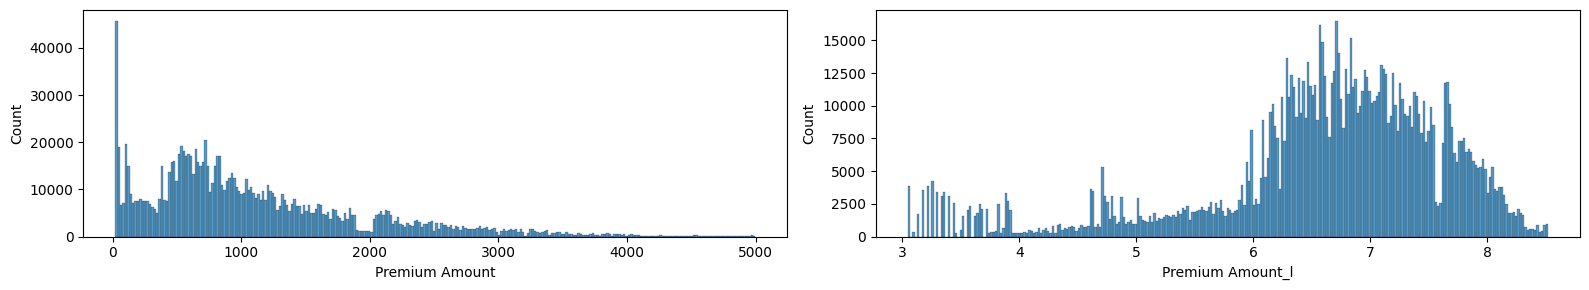

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.histplot(df_train['Premium Amount'], ax=axes[0])
sns.histplot(df_train['Premium Amount_l'], ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
df_train[target].agg(['min', 'max', 'median', 'mean']), df_train[target].mode()[0]

(min       3.044523
 max       8.517193
 median    6.771935
 mean      6.593888
 Name: Premium Amount_l, dtype: float32,
 3.2580965)

In [14]:
s_tgt_cnt = df_train['Premium Amount'].value_counts().sort_index()
s_tgt_cnt

Premium Amount
20.0      3849
21.0       362
22.0      1698
23.0      3524
24.0      3901
          ... 
4992.0       1
4994.0       1
4996.0       1
4997.0       2
4999.0       1
Name: count, Length: 4794, dtype: int64

<Axes: xlabel='Premium Amount', ylabel='count'>

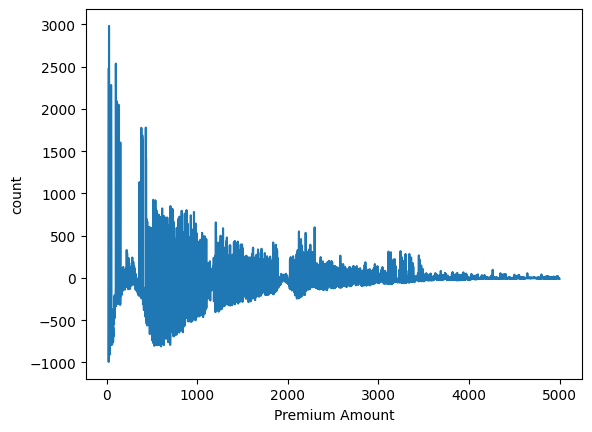

In [15]:
s_tgt_cnt_diff = s_tgt_cnt - s_tgt_cnt.rolling(100, center = True, min_periods = 1).mean()
sns.lineplot(
    s_tgt_cnt_diff
)

<Axes: xlabel='Premium Amount_l', ylabel='Count'>

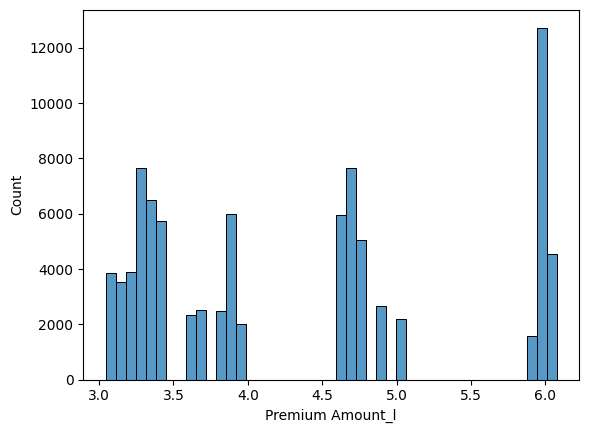

In [16]:
sns.histplot(
    df_train.loc[df_train['Premium Amount'].map(s_tgt_cnt_diff) > 1000, target]
)

# Categorical Variables

In [17]:
from scipy.stats import kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

In [18]:
pd.concat([
    df_train[i].value_counts().to_frame().pipe(lambda x: x.set_index(pd.MultiIndex.from_product([[i], x.index.tolist()], names=['Var', 'Cat'])))
    for i in X_nom
], axis = 0)

count
Var            Cat                  
Marital Status Single         395391
               Married        394316
               Divorced       391764
Occupation     Employed       282750
               Self-Employed  282645
               Unemployed     276530
Property Type  House          400349
               Apartment      399978
               Condo          399673

In [19]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = False
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

Year         Month  Occupation  Customer Feedback  Location  \
stat     7.440078e+02  7.051816e+01    6.276566           4.409469  3.429708   
pvalue  1.495212e-158  9.736743e-11    0.043357           0.110280  0.179990   

        Education Level  Policy Type  Property Type  Exercise Frequency  \
stat           3.804265     1.907457       1.738442            2.756426   
pvalue         0.283390     0.385302       0.419278            0.430723   

        Marital Status  Smoking Status   Weekday        Day    Gender  
stat          1.167640        0.169736  3.844106  22.607314  0.017928  
pvalue        0.557764        0.680346  0.697763   0.831053  0.893486

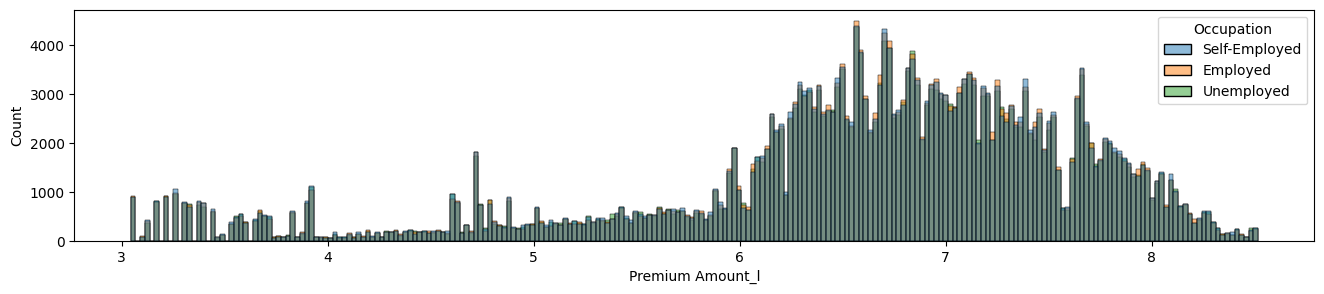

In [20]:
plt.figure(figsize=(16, 3))
sns.histplot(df_train, x=target ,hue='Occupation')
plt.show()

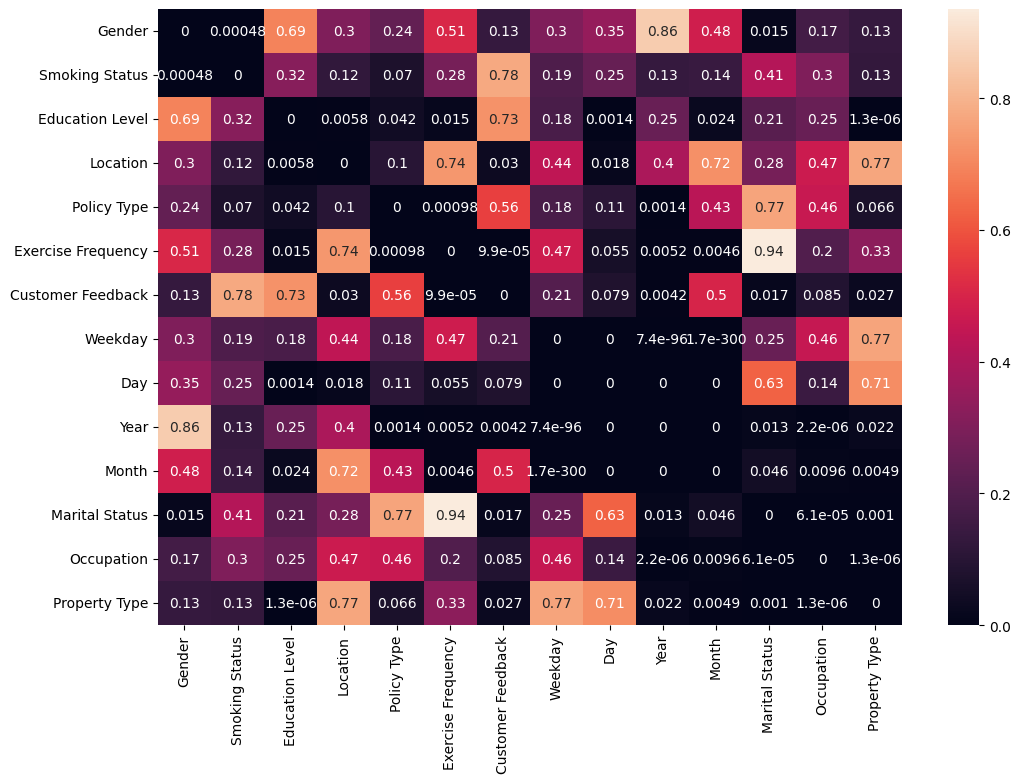

In [21]:
plt.figure(figsize=(12, 8))
df_chi2 = sc.cache_result(
    'chi2_stat',
    lambda : pd.DataFrame(
        squareform(pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns = v))[1])),
        index = X_cat, columns=X_cat
    ), rerun = 0
)
sns.heatmap(df_chi2, annot=True)
plt.show()

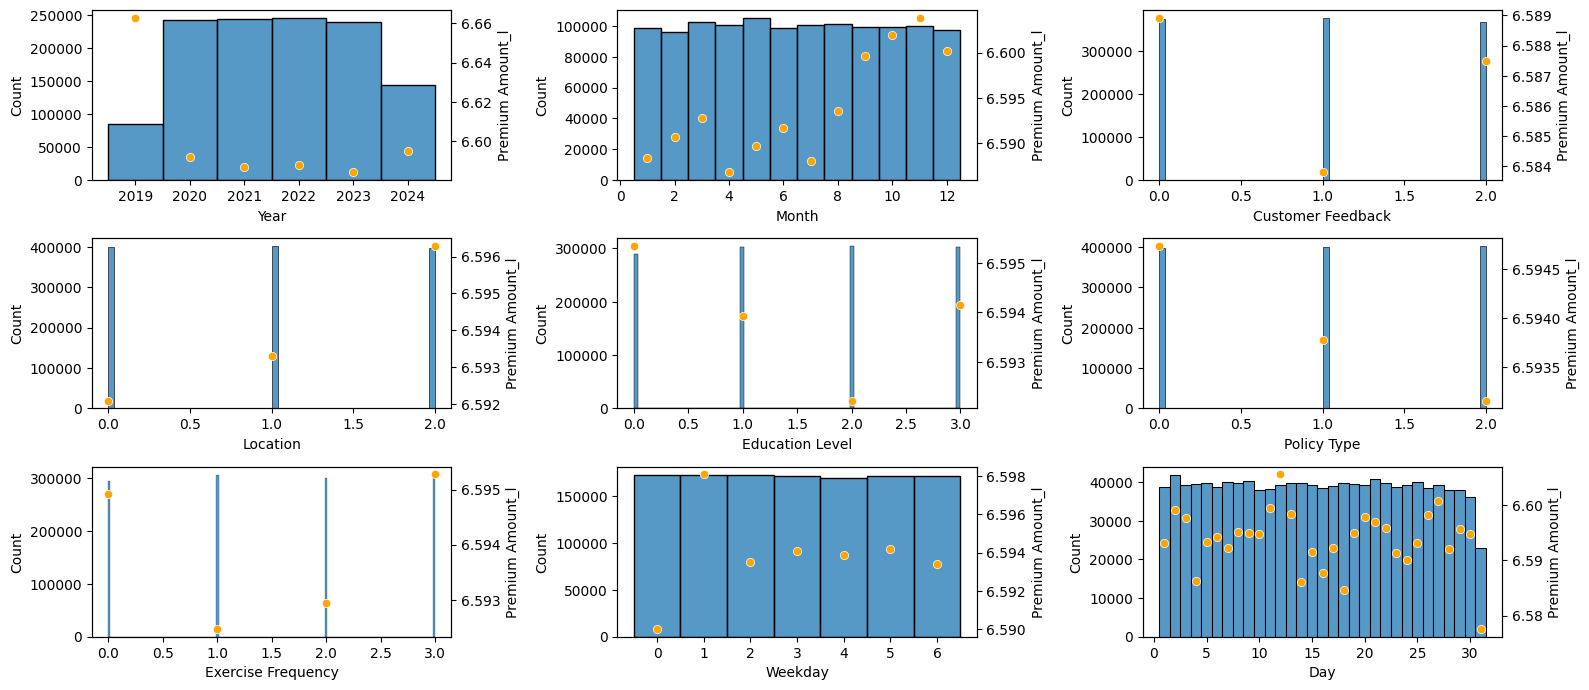

In [22]:
X = [i for i in df_kruskal_tgt.T['pvalue'].sort_values(ascending=True).index if i in X_ord]
sc.cache_fig('hist_and_scatter_ord',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

### Year와 Month의 관계


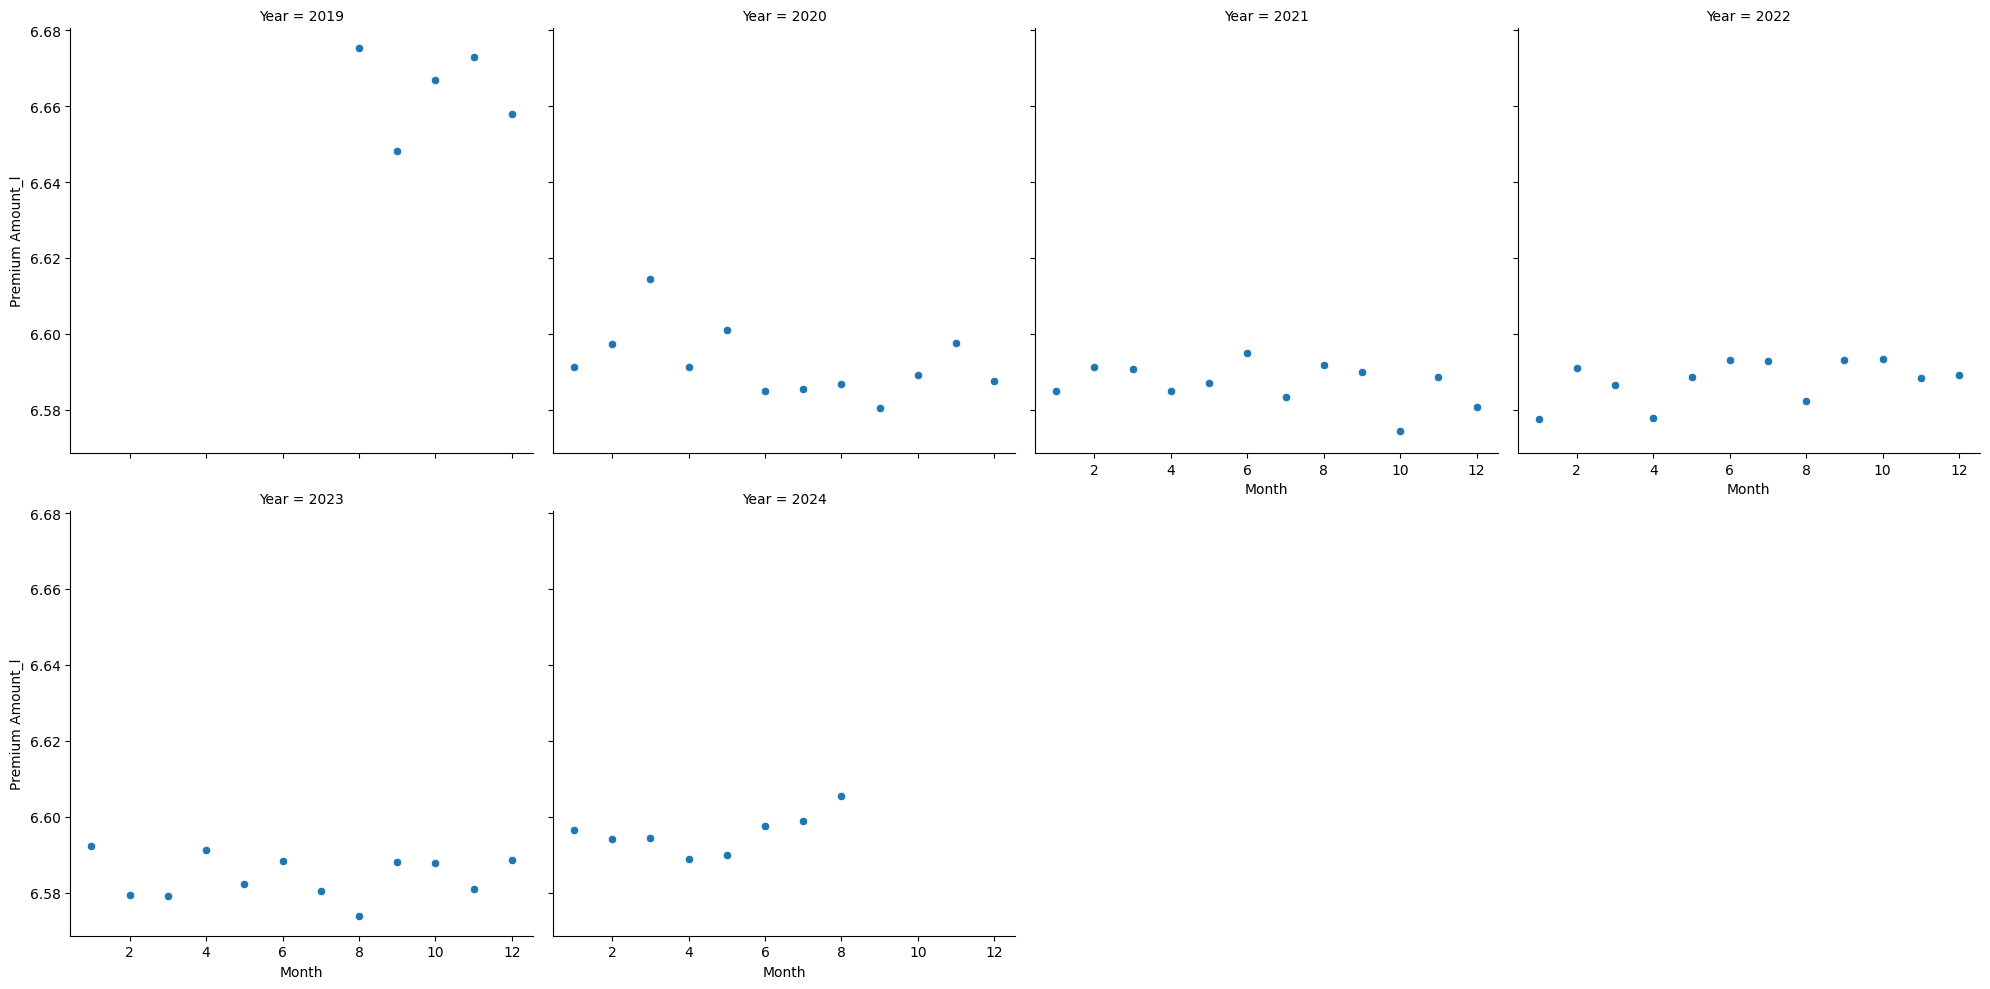

In [23]:
df_train.groupby(['Year', 'Month'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Month', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

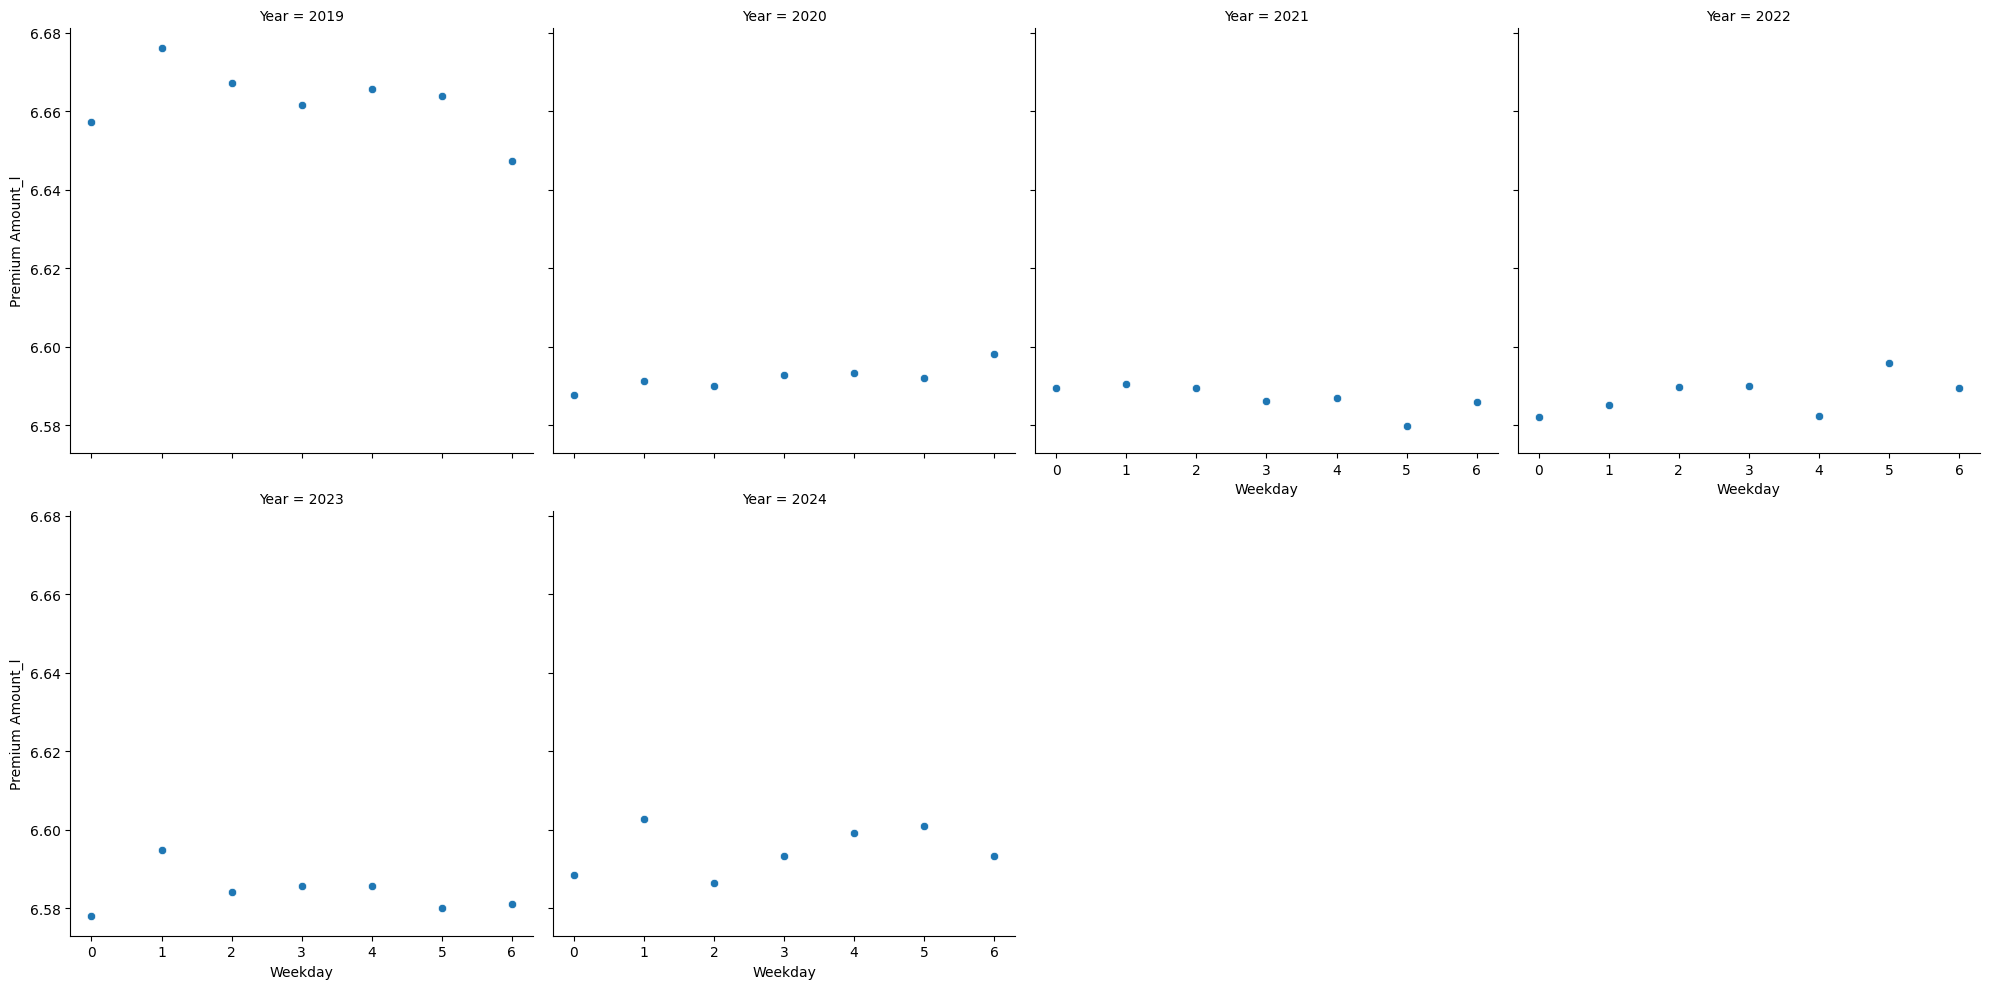

In [24]:
df_train.groupby(['Year', 'Weekday'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Weekday', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

# Numeric Variables

In [25]:
from scipy.stats import kruskal, spearmanr, pearsonr

## Spearman with target

In [26]:
df_spearman_target = sc.cache_result('spearman_target',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target

Annual Income  Credit Score  Previous Claims  Health Score       Age  \
stat        -0.061437     -0.043928         0.044549  1.601483e-02 -0.002329   
pvalue       0.000000      0.000000         0.000000  9.044248e-65  0.011369   

        Number of Dependents  Vehicle Age  Insurance Duration  
stat               -0.001610     0.000870           -0.000071  
pvalue              0.092669     0.340707            0.937799

## Spearman between variables

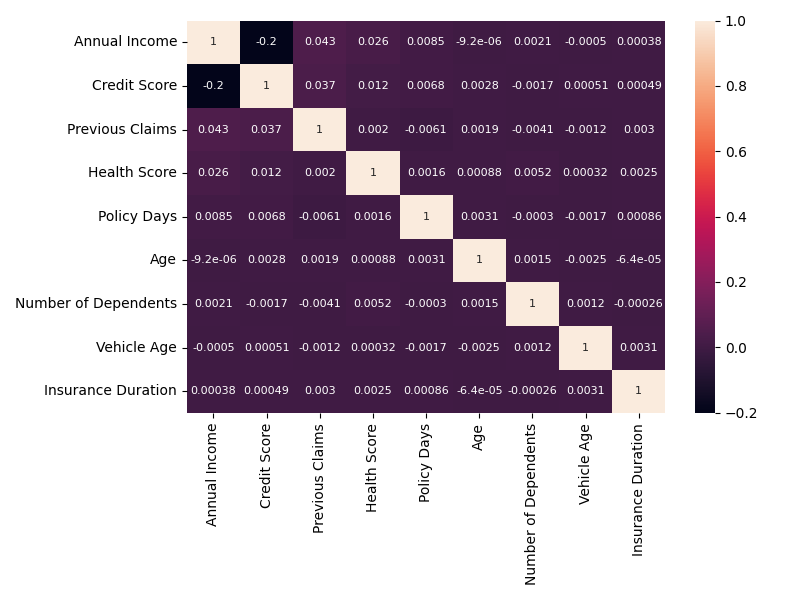

In [27]:
sc.cache_fig('spearman_between variables',
    lambda x: sns.heatmap(
        df_train[
            df_spearman_target.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

## Kruskal with Categorical Variables

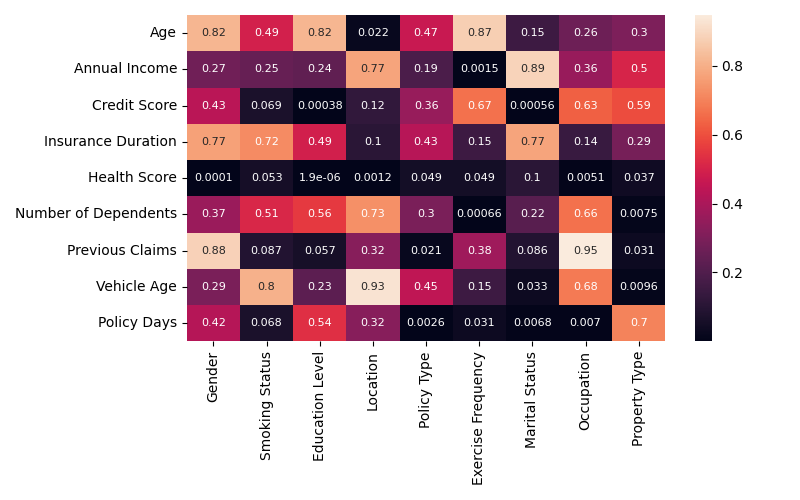

In [28]:
df_kruskal_cat = sc.cache_result('kruskal_cat', 
    lambda : pd.concat([
        df_train.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat',
    lambda x: sns.heatmap(
        df_kruskal_cat, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

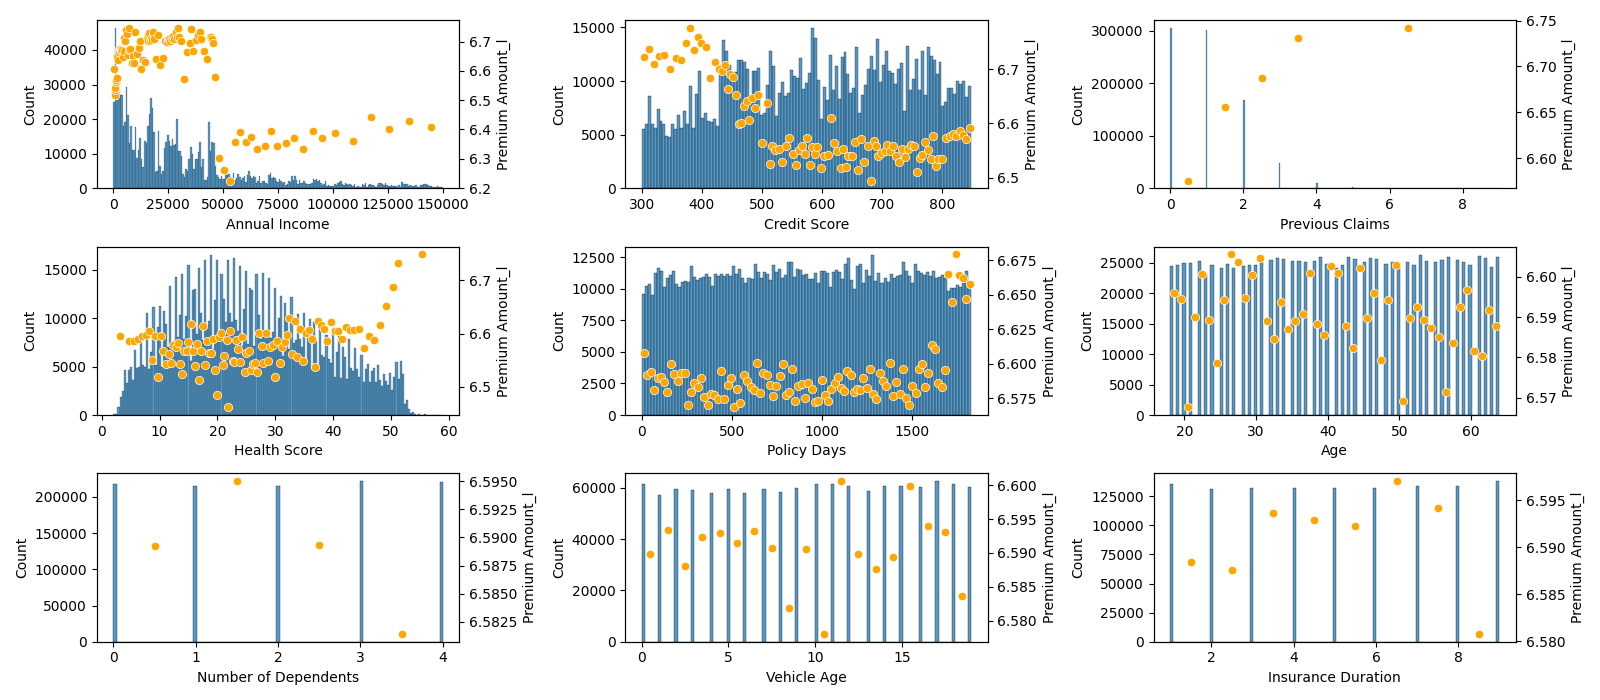

In [29]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

In [30]:
pd.concat([
    pd.Series(
        kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
    )
    for i in ['Age', 'Vehicle Age', 'Insurance Duration', 'Number of Dependents']
], axis=1)

Age  Vehicle Age  Insurance Duration  Number of Dependents
stat    89.648062    32.696028           34.352082             24.190392
pvalue   0.000124     0.026054            0.000035              0.000073

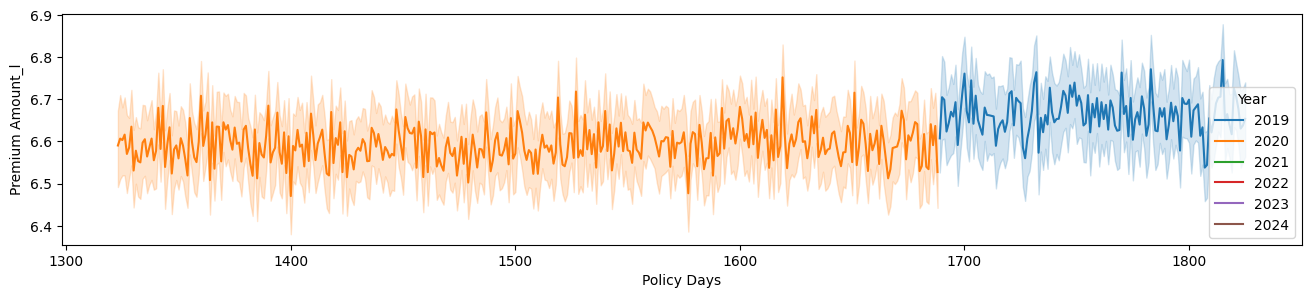

In [31]:
plt.figure(figsize = (16, 3))
sns.lineplot(df_train.query('Year == 2019 or Year == 2020'), x = 'Policy Days', y = target, hue='Year')
plt.show()

In [32]:
# 2020-1-1을 기점으로 target의 변화가 생깁니다.
df_train = pd_vars.put_proc('year_2019', df_train, [(lambda x: (x['Year'] == 2019).rename('Year_2019'), '2019년 여부')])
df_test = dproc.join_and_assign(df_test, pd_vars.proc('year_2019', df_test))

In [33]:
df_train.groupby(['Year_2019'])[target].std()

Year_2019
False    1.093716
True     1.121104
Name: Premium Amount_l, dtype: float32

In [34]:
pd.concat([
    df_train['Previous Claims'].fillna(-1).value_counts().rename('cnt'),
    df_train.groupby(df_train['Previous Claims'].fillna(-1))[target].agg(['mean', 'std'])
], axis=1).T

Previous Claims           -1.0            0.0            1.0            2.0  \
cnt              364029.000000  305433.000000  300811.000000  167661.000000   
mean                  6.570288       6.573611       6.584603       6.659235   
std                   1.089575       1.093892       1.091891       1.112314   

Previous Claims           3.0           4.0          5.0         6.0  \
cnt              49011.000000  10668.000000  2018.000000  302.000000   
mean                 6.691059      6.734332     6.727364    6.809397   
std                  1.106070      1.090079     1.098397    1.093210   

Previous Claims        7.0       8.0      9.0  
cnt              58.000000  8.000000  1.00000  
mean              7.024037  6.778293  7.38709  
std               0.848970  1.193785      NaN

In [35]:
df_train['Previous Claims_C'] = df_train['Previous Claims'].fillna(-1).clip(-1, 7)

In [36]:
df_train.groupby('Year_2019')[['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims', target]].mean()

Annual Income  Credit Score  Health Score  Previous Claims  \
Year_2019                                                               
False       32480.503906    592.682922     25.598755         1.002977   
True        36263.808594    596.130676     25.812834         0.998899   

           Premium Amount_l  
Year_2019                    
False              6.588686  
True               6.662757

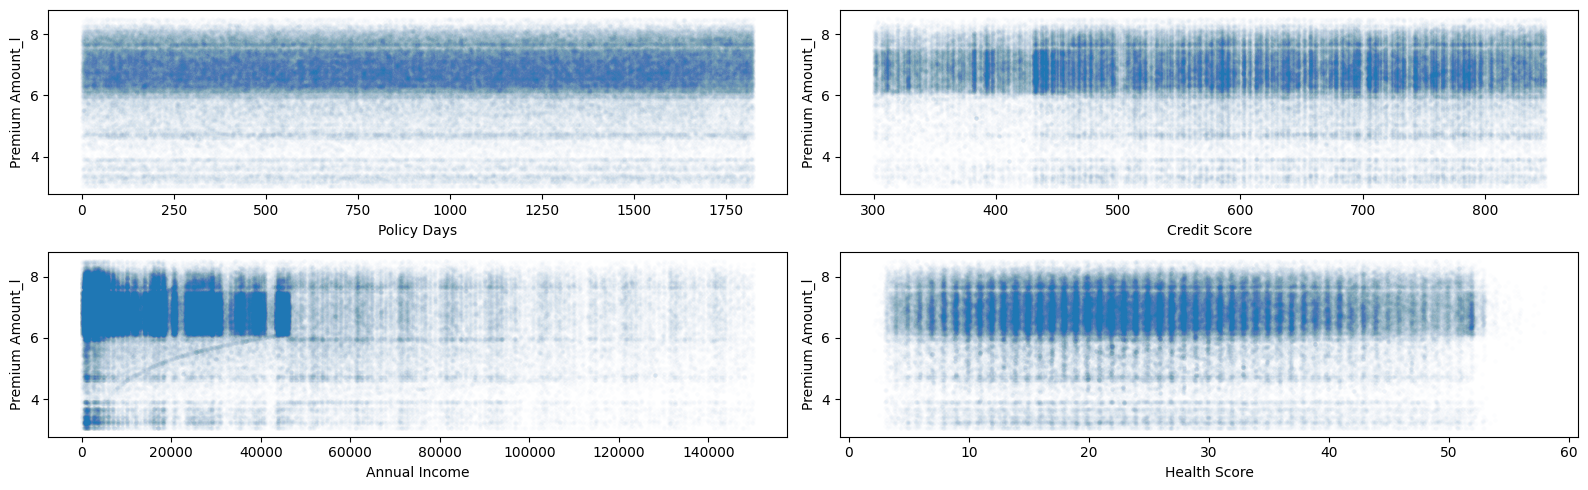

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(16, 5))
for i, ax in zip(['Policy Days', 'Credit Score', 'Annual Income', 'Health Score'], axes.flatten()):
    sns.scatterplot(
        df_train.sample(frac = 0.2), x = i, y = target, alpha = 0.01, s = 10, ax = ax
    )
plt.tight_layout()
plt.show()

In [38]:
display(df_train.groupby(df_train['Annual Income'] >= 46500)[target].std())
df_train['Annual Income_46K'] = df_train['Annual Income'] >= 46500

Annual Income
False    1.017953
True     1.318848
Name: Premium Amount_l, dtype: float32

In [39]:
df_train['Annual Income_b'] = pd.cut(df_train['Annual Income'], bins=[0, 2400, 46500, np.inf], labels=[0, 1, 2])
display(df_train.groupby('Annual Income_b', observed=True)[target].std())

Annual Income_b
0    1.209969
1    0.964980
2    1.318850
Name: Premium Amount_l, dtype: float32

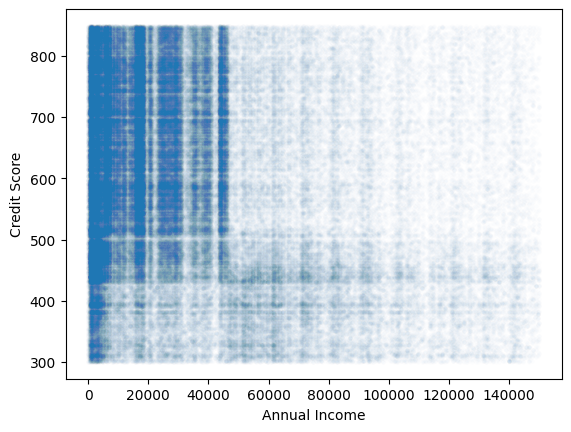

In [40]:
sns.scatterplot(df_train.sample(frac = 0.3), x = 'Annual Income', y = 'Credit Score', s = 10, alpha = 0.01)
plt.show()

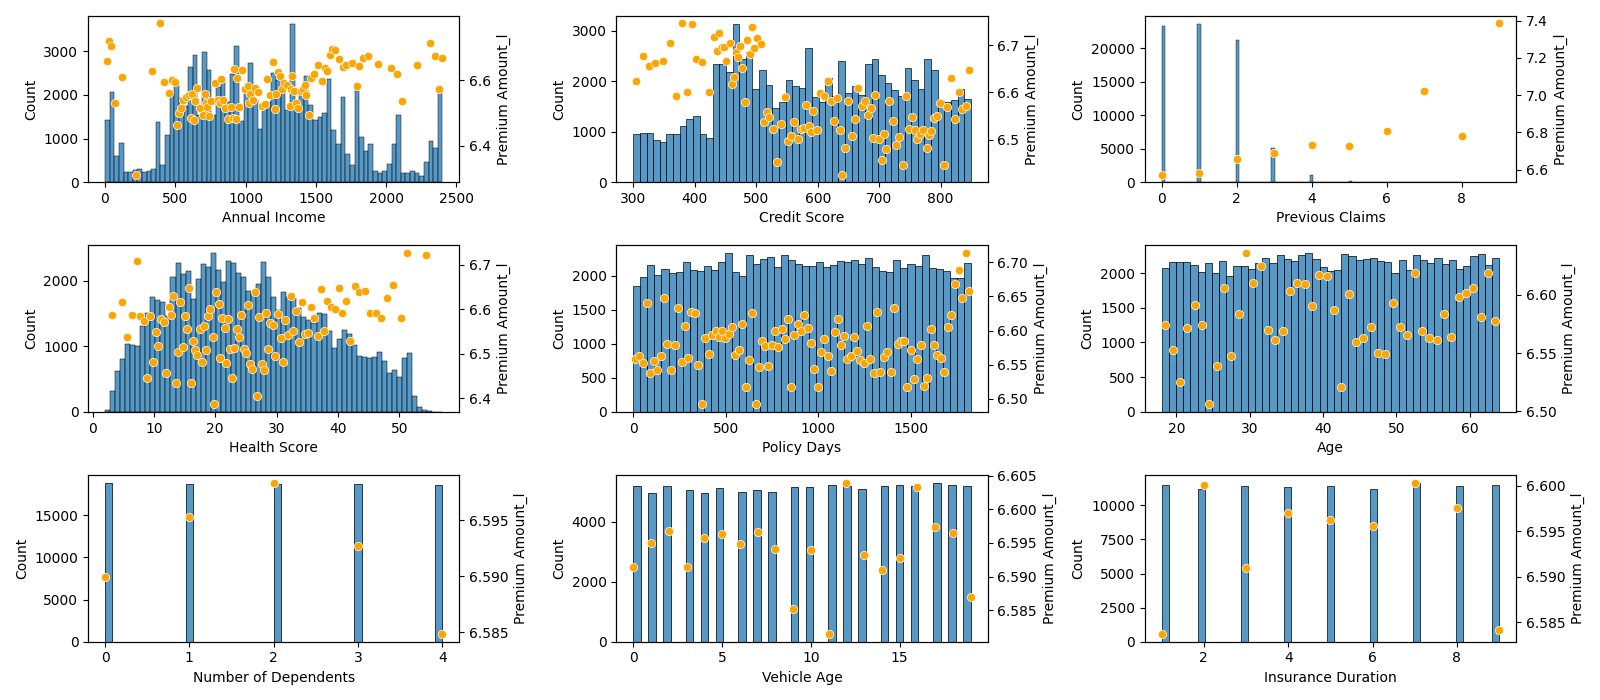

In [41]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter2',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 0'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

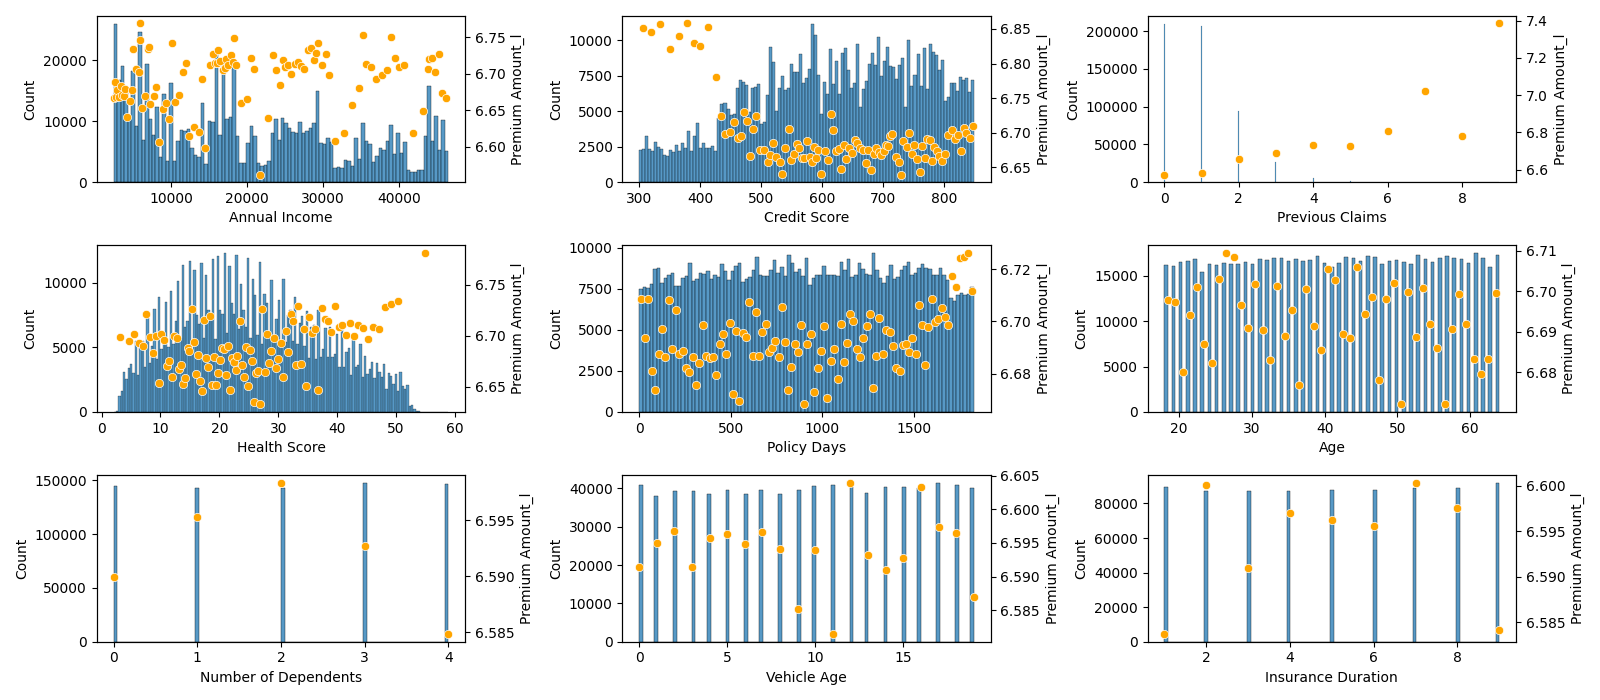

In [42]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter3',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 1'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

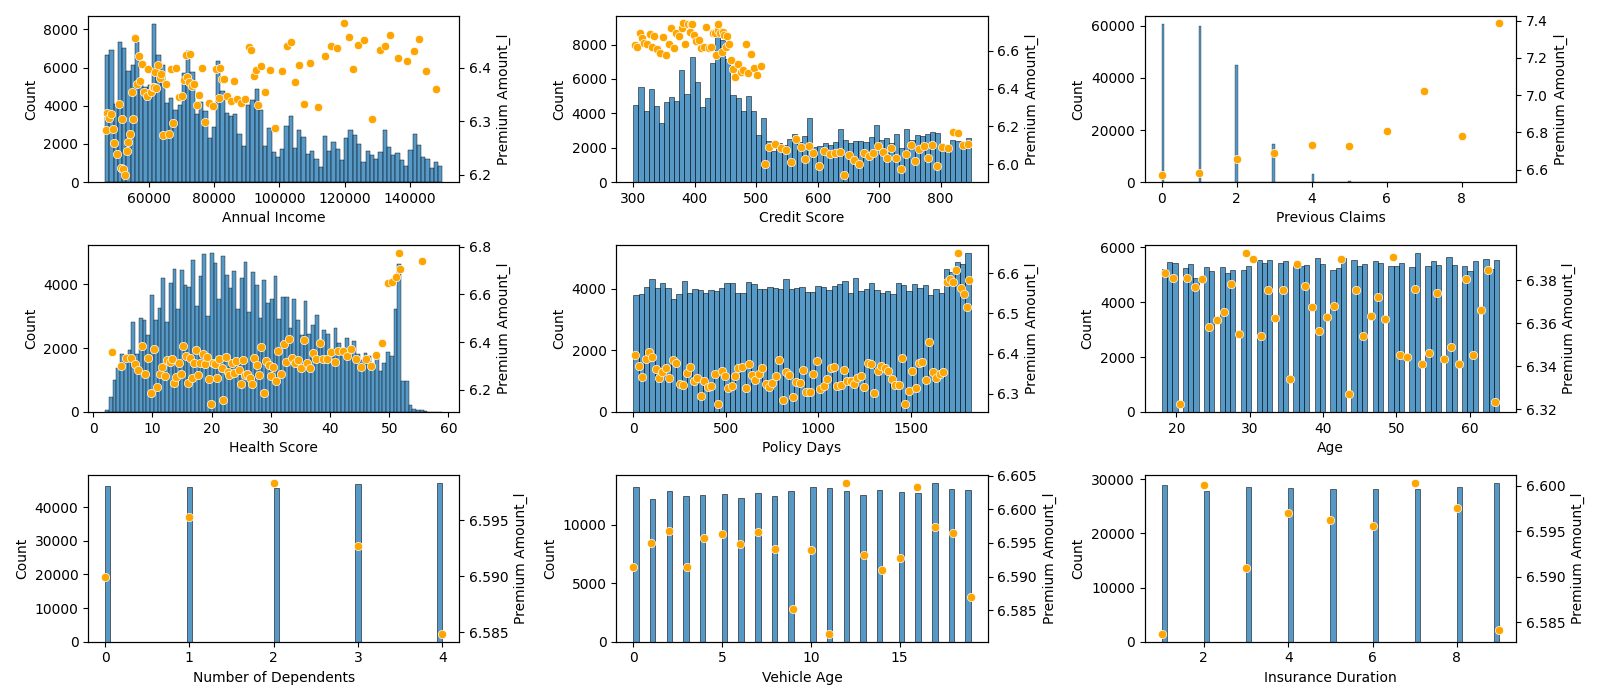

In [43]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter4',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 2'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

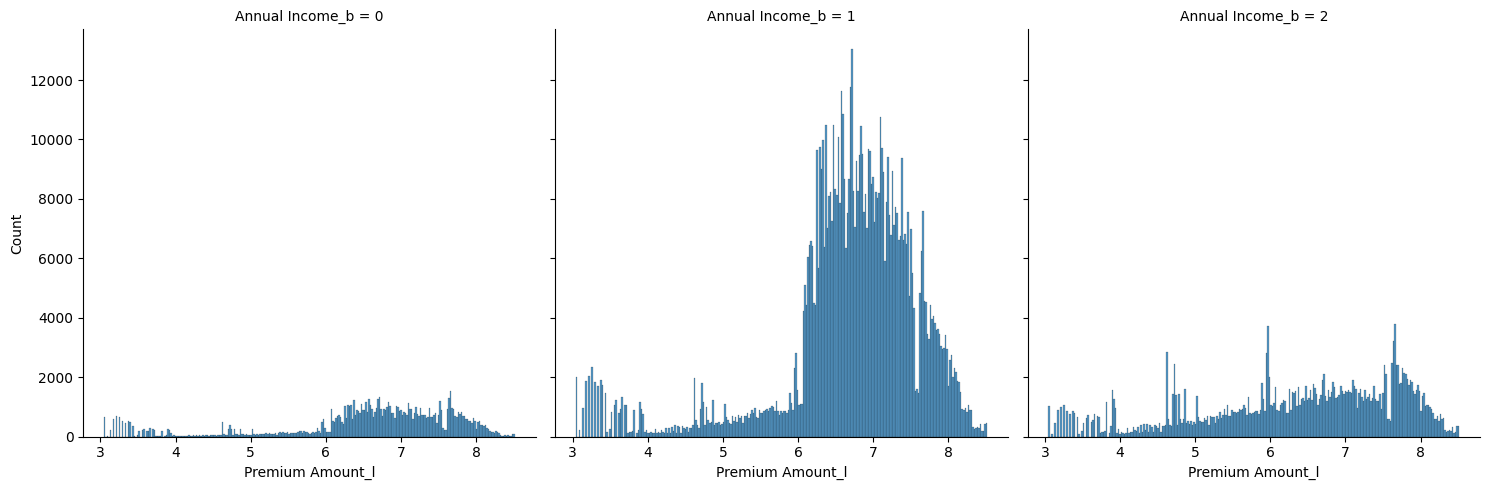

In [44]:
sns.displot(df_train, x = target , col = 'Annual Income_b')

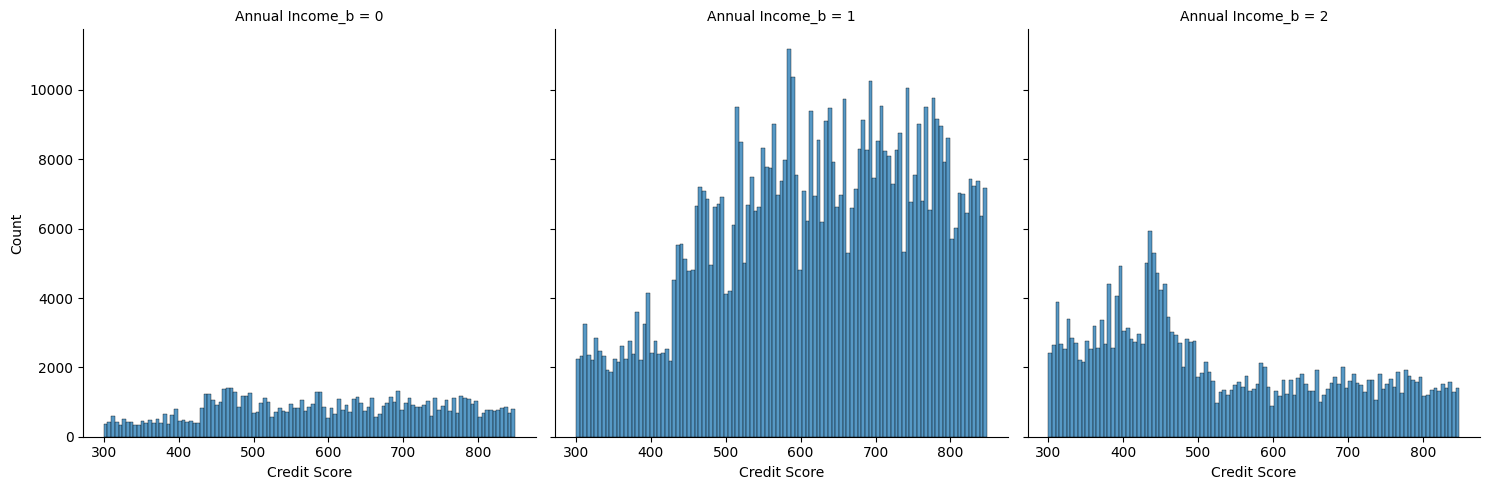

In [45]:
sns.displot(df_train, x = 'Credit Score' , col = 'Annual Income_b')

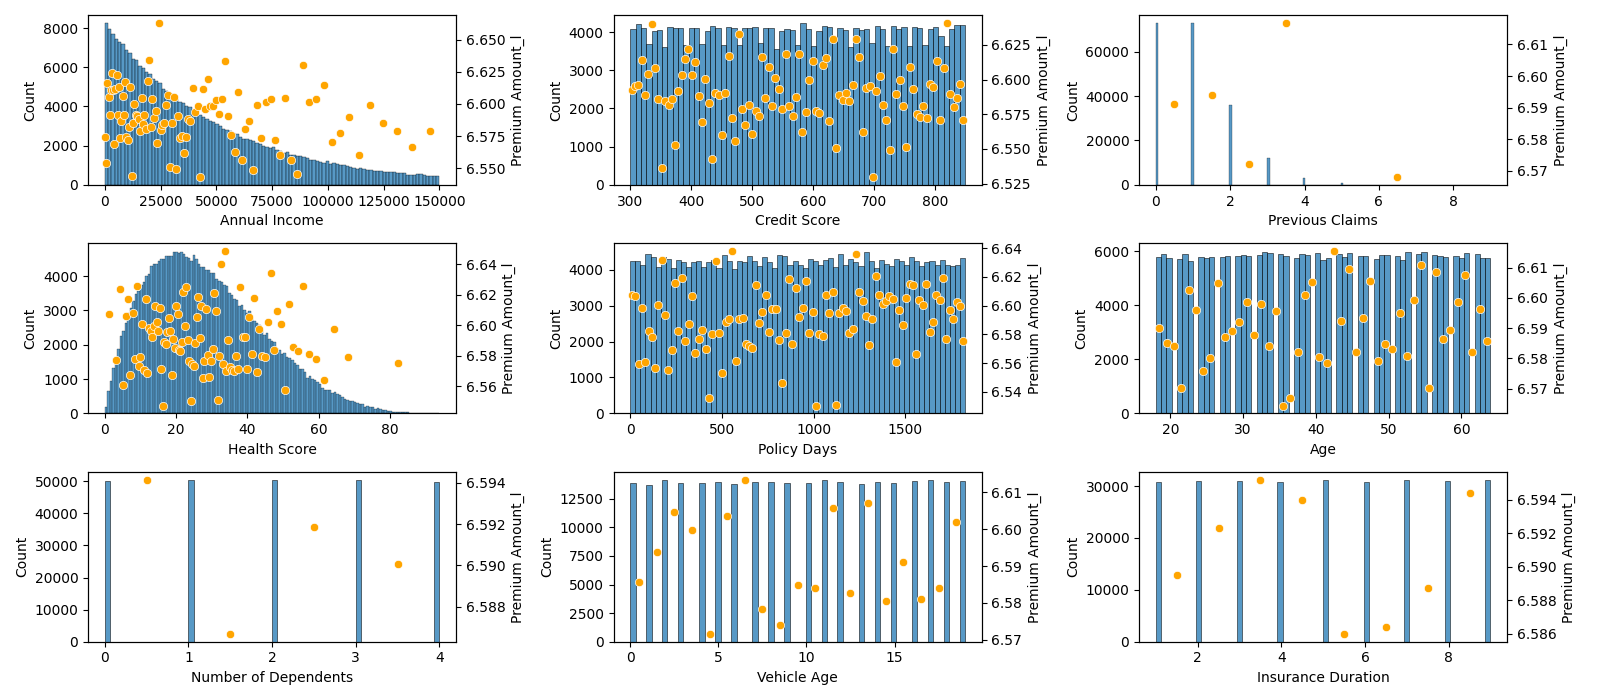

In [46]:
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter_org',
    lambda axes: [hist_and_scatter(df_org, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw=0
)

# Missing Variables

In [47]:
pd.concat([
    df_train[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(train)').sort_values(ascending=False).to_frame().T,
    df_test[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(test)').sort_values(ascending=False).to_frame().T,
    df_org[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(org)').sort_values(ascending=False).to_frame().T
], axis=0).fillna(0)

Previous Claims  Occupation  Credit Score  \
na_rate(train)         0.303358    0.298396      0.114902   
na_rate(test)          0.303503    0.298906      0.114314   
na_rate(org)           0.291501    0.291501      0.100000   

                Number of Dependents  Customer Feedback  Health Score  \
na_rate(train)              0.091393           0.064853      0.061730   
na_rate(test)               0.091412           0.065345      0.061811   
na_rate(org)                0.100000           0.065800      0.038001   

                Annual Income       Age  Marital Status  Vehicle Age  \
na_rate(train)       0.037457  0.015588        0.015441     0.000005   
na_rate(test)        0.037325  0.015611        0.015420     0.000004   
na_rate(org)         0.050043  0.016801        0.017998     0.000000   

                Insurance Duration  
na_rate(train)        8.333333e-07  
na_rate(test)         2.500000e-06  
na_rate(org)          0.000000e+00

In [48]:
def get_isna_proc(X_isna):
    desc = {'{}_isna'.format(i): '{}의 결측 여부'.format(i) for i in X_isna}
    return desc, lambda x: x[X_isna].isna().rename(columns = lambda x: x + '_isna')


isna_desc, isna_proc = get_isna_proc(
    ['Previous Claims', 'Occupation', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age', 'Marital Status']
)
df_train = pd_vars.put_proc('isna', df_train, [(isna_proc, isna_desc)])
df_test = dproc.join_and_assign(df_test, pd_vars.proc('isna', df_test))
df_org = dproc.join_and_assign(
    df_org, pd_vars.proc('isna', df_org)
)

## Missing Value Processing

In [49]:
# 수치형 변수의 결측치를 0으로 채웁니다.
X_fn = ['Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age']
df_fz = df_train[X_fn].fillna(0).astype('int').rename(columns = lambda x: x + '_fz')
df_train = dproc.join_and_assign(
    df_train, df_fz
)    

In [50]:
def get_fillna_proc(df):
    id_m = df['Insurance Duration'].mode()[0]
    desc = {
        'Occupation_funk': 'Occupation의 결측치를 Unknown으로 대체',
        'Marital Status': 'Marital Status의 결측치를 Unknown으로 대체',
        'Customer Feedback': 'Customer Feedback의 결측치를 -1으로 대체',
        'Previous Claims': 'Previous Claims의 결측치를 -1으로 대체',
        'Vehicle Age': 'Vehicle Age의 결측치를 -1으로 대체',
        'Insurance Duration': 'Insurance Duration의 결측치를 최빈값으로 대체',
    }
    return desc, lambda x: pd.concat([
        x['Occupation'].cat.add_categories('Unknown').fillna('Unknown').rename('Occupation_funk'),
        x['Marital Status'].cat.add_categories('Unknown').fillna('Unknown').rename('Marital Status_funk'),
        x['Customer Feedback'].fillna(-1).astype('int8').rename('Customer Feedback_fm1'),
        x['Previous Claims'].fillna(-1).astype('int8').rename('Previous Claims_fm1'),
        x['Vehicle Age'].fillna(-1).astype('int8').rename('Vehicle Age_fm1'),
        x['Insurance Duration'].fillna(id_m).astype('int').rename('Insurance Duration_fm'),
    ], axis = 1)

fillna_desc, fillna_proc = get_fillna_proc(df_train)
df_train = pd_vars.put_proc('fillna', df_train, [(fillna_proc, fillna_desc)])
df_test = dproc.join_and_assign(df_test, pd_vars.proc('fillna', df_test))
df_org = dproc.join_and_assign(df_org, pd_vars.proc('fillna', df_org))

# Train/Test/Org Difference

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_roc_auc_diff(df_0, df_1, X_input):
    df_diff = pd.concat([
        df_0[X_input].assign(is_1 = False),
        df_1[X_input].assign(is_1 = True)
    ], axis = 0)
    df_train_diff, df_test_diff = train_test_split(df_diff, train_size = 0.8, stratify = df_diff['is_1'])
    clf_diff = lgb.LGBMClassifier(random_state=123, verbose = 0)
    clf_diff.fit(df_diff[X_input], df_diff['is_1'], categorical_feature = X_cat)
    return (
        roc_auc_score(df_test_diff['is_1'], clf_diff.predict_proba(df_test_diff[X_input])[:, 1]),
        pd.Series(clf_diff.feature_importances_, index=X_input)
    )
(roc1, s_imp1), (roc2, s_imp2) = sc.cache_result('diff_result',
    lambda : (
        get_roc_auc_diff(df_train, df_test, X_cat + X_num),
        get_roc_auc_diff(df_train, df_org, X_cat + X_num + ['Premium Amount'])
    ), rerun=0
)
roc1, roc2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


(0.5521235732291666, 0.812339463238722)

In [52]:
s_imp2.sort_values(ascending=False).iloc[:15].to_frame().T

Annual Income  Health Score  Premium Amount  Credit Score  \
0            956           694             625           325   

   Customer Feedback  Previous Claims  Year  Day  Marital Status  Month  \
0                131              128    52   45              12     11   

   Number of Dependents  Education Level  Insurance Duration  Occupation  Age  
0                    11                4                   3           1    1

Train은 Test와 구분이 어려운 것으로 보아 차이가 크지 않음을 알 수 있고,

Org와는 차이가 보입니다. Org 데이터를 포함하여 학습시키는 것은 성능의 개선을 주지 않을 가능성이 큽니다. 

In [53]:
from sklearn.metrics import mean_squared_error
def check_improve():
    df_org[target] = np.log(df_org['Premium Amount'] + 1e-7)
    df_train_2, df_valid = train_test_split(df_train, train_size = 0.8)
    return (
        mean_squared_error(
            df_valid[target],
            lgb.LGBMRegressor(random_state = 123, verbose=0).fit(df_train_2[X_cat + X_num], df_train_2[target]).predict(df_valid[X_cat + X_num])
        ),
        mean_squared_error(
            df_valid[target],
            pd.concat([df_train_2[X_cat + X_num + [target]], df_org[X_cat + X_num + [target]]])\
            .pipe(lambda x: lgb.LGBMRegressor(random_state = 123, verbose=0).fit(x[X_cat + X_num], x[target]).predict(df_valid[X_cat + X_num]))
        )
    )
sc.cache_result('check_improve', check_improve)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


(1.0944429298664637, 1.1147400898943045)

# Marital Status & Customer Feedback

In [54]:
df_train = pd_vars.put_proc('combine', df_train,
    [(
        lambda x: dproc.combine_cat(df_train[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
            CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
        ).drop(columns = ['Customer Feedback_fm1']), '_').rename('Marital_Feedback'), 'Marital Status_funk와 Customer Feedback_fm1을 결합'
    )]
)
df_test = dproc.join_and_assign(df_test, pd_vars.proc('combine', df_test))

In [55]:
kruskal(
    *df_train.groupby('Marital_Feedback', observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=1429.045687854355, pvalue=9.324099009910078e-296)

In [56]:
sc.cache_result(
    'kruskal_MC',
    lambda : pd.concat([
        pd.Series(kruskal(
            *df_train.groupby('Marital_Feedback', observed = True)[i].agg(lambda x: list(x.dropna()))
        ), index = ['stat', 'pvalue'], name=i)
        for i in X_num
    ], axis=1), rerun = 0
)

Age  Annual Income  Credit Score  Insurance Duration  \
stat    18.548716   1.299060e+03  4.602663e+02           10.246732   
pvalue   0.234917  8.450317e-268  1.404620e-88            0.803939   

        Health Score  Number of Dependents  Previous Claims  Vehicle Age  
stat       34.742899             16.092080     1.719204e+02    42.576379  
pvalue      0.002675              0.375959     1.005699e-28     0.000183

In [57]:
sc.cache_result(
    'chi2_MC',
    lambda : pd.concat([
        pd.Series(chi2_contingency(
            df_train.groupby(['Marital_Feedback', i], observed = True).size().unstack()
        )[:2], index = ['stat', 'pvalue'], name=i)
        for i in X_cat
    ], axis=1)
).dropna(axis=1).sort_values('pvalue', axis=1)

Year  Property Type  Occupation   Location     Weekday  \
stat    1.560036e+02      65.727727   61.623324  48.266993  117.932713   
pvalue  1.254669e-07       0.000177    0.000583   0.018643    0.025749   

           Gender  Exercise Frequency       Month         Day  \
stat    25.511365           60.863322  174.803724  463.037867   
pvalue   0.043483            0.057431    0.285739    0.325404   

        Education Level  Smoking Status  Policy Type  
stat          46.059221       15.282396    19.940130  
pvalue         0.428185        0.431274     0.918091

# Interaction

In [58]:
def com_kruskal(v1, v2, t = target):
    return kruskal(
        *df_train[[v1, v2, t]].assign(
            V1S = lambda x: x[v1].astype('str').astype('category'),
            V2S = lambda x: x[v2].astype('str').astype('category'),
        ).drop(columns = [v1, v2]).pipe(
            lambda x: x.groupby(dproc.combine_cat(x[['V1S', 'V2S']], '_'), observed = True)[t].agg(lambda x: list(x.dropna()))
        )
    )
com_kruskal('Customer Feedback', 'Marital Status')

KruskalResult(statistic=1429.045687854355, pvalue=9.324099009910078e-296)

In [59]:
from itertools import combinations
df_com_kru = sc.cache_result('com_kruskal',
    lambda : pd.concat([
        pd.Series([a, b, com_kruskal(
        a, b
        )[1]], index = ['v1', 'v2', 'pvalue'])
        for a, b in combinations(['Occupation', 'Property Type', 'Age', 'Number of Dependents', 'Vehicle Age'] + X_ord[:-5] + X_bool, 2)
    ], axis=1), rerun = 0
).T
df_com_kru.sort_values('pvalue').head(20)

v1                    v2    pvalue
2             Occupation  Number of Dependents       0.0
33  Number of Dependents        Smoking Status       0.0
32  Number of Dependents                Gender       0.0
30  Number of Dependents           Policy Type       0.0
29  Number of Dependents              Location       0.0
11         Property Type  Number of Dependents       0.0
31  Number of Dependents    Exercise Frequency       0.0
4             Occupation       Education Level       0.0
9             Occupation        Smoking Status       0.0
28  Number of Dependents       Education Level       0.0
5             Occupation              Location       0.0
8             Occupation                Gender       0.0
0             Occupation         Property Type       0.0
6             Occupation           Policy Type       0.0
19                   Age  Number of Dependents       0.0
7             Occupation    Exercise Frequency       0.0
27  Number of Dependents           Vehicle Age  0.000004
3             Occupation           Vehicle Age  0.000006
1             Occupation                   Age  0.000007
25                   Age                Gender  0.000008

In [60]:
from itertools import combinations
df_com_kru_pc = sc.cache_result('com_kruskal_pc',
    lambda : pd.concat([
        pd.Series([a, b, com_kruskal(
        a, b, 'Previous Claims'
        )[1]], index = ['v1', 'v2', 'pvalue'])
        for a, b in combinations(['Occupation', 'Property Type', 'Age', 'Number of Dependents', 'Vehicle Age'] + X_ord[:-5] + X_bool, 2)
    ], axis=1), rerun = 0
).T
df_com_kru_pc.sort_values('pvalue').head(30)

v1                    v2    pvalue
38           Vehicle Age                Gender       0.0
33  Number of Dependents        Smoking Status       0.0
2             Occupation  Number of Dependents       0.0
28  Number of Dependents       Education Level       0.0
30  Number of Dependents           Policy Type       0.0
39           Vehicle Age        Smoking Status       0.0
32  Number of Dependents                Gender       0.0
11         Property Type  Number of Dependents       0.0
29  Number of Dependents              Location       0.0
35           Vehicle Age              Location       0.0
12         Property Type           Vehicle Age       0.0
31  Number of Dependents    Exercise Frequency       0.0
37           Vehicle Age    Exercise Frequency  0.000021
6             Occupation           Policy Type  0.000508
8             Occupation                Gender  0.000836
0             Occupation         Property Type  0.002548
15         Property Type           Policy Type  0.005144
9             Occupation        Smoking Status  0.006173
4             Occupation       Education Level  0.007727
13         Property Type       Education Level  0.008402
19                   Age  Number of Dependents    0.0103
7             Occupation    Exercise Frequency   0.01645
5             Occupation              Location  0.018622
50           Policy Type                Gender  0.021457
16         Property Type    Exercise Frequency   0.04072
41       Education Level           Policy Type  0.051808
51           Policy Type        Smoking Status  0.057297
14         Property Type              Location  0.059087
21                   Age       Education Level  0.066035
18         Property Type        Smoking Status  0.067123

In [61]:
from itertools import combinations
df_com_kru_pc = sc.cache_result('com_kruskal_a',
    lambda : pd.concat([
        pd.Series([a, b, com_kruskal(
        a, b, 'Annual Income'
        )[1]], index = ['v1', 'v2', 'pvalue'])
        for a, b in combinations(['Occupation', 'Property Type', 'Age', 'Number of Dependents', 'Vehicle Age'] + X_ord[:-5] + X_bool, 2)
    ], axis=1), rerun = 0
).T.sort_values('pvalue')
df_com_kru_pc.head(30)

v1                    v2    pvalue
31  Number of Dependents    Exercise Frequency       0.0
30  Number of Dependents           Policy Type       0.0
29  Number of Dependents              Location       0.0
33  Number of Dependents        Smoking Status       0.0
32  Number of Dependents                Gender       0.0
11         Property Type  Number of Dependents       0.0
2             Occupation  Number of Dependents       0.0
28  Number of Dependents       Education Level       0.0
19                   Age  Number of Dependents  0.002105
24                   Age    Exercise Frequency  0.008544
53    Exercise Frequency        Smoking Status  0.008852
52    Exercise Frequency                Gender  0.011204
49           Policy Type    Exercise Frequency  0.015561
7             Occupation    Exercise Frequency  0.024192
42       Education Level    Exercise Frequency   0.03304
44       Education Level        Smoking Status  0.055344
36           Vehicle Age           Policy Type  0.061068
16         Property Type    Exercise Frequency  0.066064
46              Location    Exercise Frequency  0.078581
13         Property Type       Education Level  0.089645
38           Vehicle Age                Gender  0.095552
10         Property Type                   Age  0.112217
6             Occupation           Policy Type  0.140457
18         Property Type        Smoking Status  0.253483
43       Education Level                Gender  0.255082
25                   Age                Gender  0.282307
12         Property Type           Vehicle Age  0.283867
4             Occupation       Education Level  0.291286
51           Policy Type        Smoking Status  0.314839
8             Occupation                Gender  0.334371

In [62]:
com_kruskal('Vehicle Age', 'Gender', 'Previous Claims')

KruskalResult(statistic=130.7571920452451, pvalue=2.6581485636525218e-11)

In [63]:
from itertools import combinations
df_com_kru_pc = sc.cache_result('com_kruskal_c',
    lambda : pd.concat([
        pd.Series([a, b, com_kruskal(
        a, b, 'Credit Score'
        )[1]], index = ['v1', 'v2', 'pvalue'])
        for a, b in combinations(['Occupation', 'Property Type', 'Age', 'Number of Dependents', 'Vehicle Age'] + X_ord[:-5] + X_bool, 2)
    ], axis=1), rerun = 0
).T
df_com_kru_pc.sort_values('pvalue').head(30)

v1                    v2    pvalue
2             Occupation  Number of Dependents       0.0
33  Number of Dependents        Smoking Status       0.0
32  Number of Dependents                Gender       0.0
28  Number of Dependents       Education Level       0.0
29  Number of Dependents              Location       0.0
30  Number of Dependents           Policy Type       0.0
4             Occupation       Education Level       0.0
11         Property Type  Number of Dependents       0.0
31  Number of Dependents    Exercise Frequency       0.0
8             Occupation                Gender       0.0
5             Occupation              Location       0.0
9             Occupation        Smoking Status       0.0
0             Occupation         Property Type       0.0
6             Occupation           Policy Type       0.0
7             Occupation    Exercise Frequency       0.0
19                   Age  Number of Dependents  0.000002
27  Number of Dependents           Vehicle Age  0.000003
1             Occupation                   Age  0.000007
3             Occupation           Vehicle Age  0.000184
23                   Age           Policy Type  0.000952
43       Education Level                Gender  0.001534
44       Education Level        Smoking Status   0.00215
25                   Age                Gender  0.002793
22                   Age              Location  0.003115
21                   Age       Education Level  0.003928
41       Education Level           Policy Type  0.004156
20                   Age           Vehicle Age  0.007173
40       Education Level              Location  0.007729
50           Policy Type                Gender   0.00917
13         Property Type       Education Level  0.009508

In [64]:
from itertools import combinations
df_com_kru_pc = sc.cache_result('com_kruskal_h',
    lambda : pd.concat([
        pd.Series([a, b, com_kruskal(
        a, b, 'Health Score'
        )[1]], index = ['v1', 'v2', 'pvalue'])
        for a, b in combinations(['Occupation', 'Property Type', 'Age', 'Number of Dependents'] + X_ord[:-5] + X_bool, 2)
    ], axis=1), rerun = 0
).T
df_com_kru_pc.sort_values('pvalue').head(30)

v1                    v2    pvalue
22                   Age                Gender       0.0
18                   Age       Education Level       0.0
19                   Age              Location       0.0
23                   Age        Smoking Status       0.0
24  Number of Dependents       Education Level       0.0
20                   Age           Policy Type       0.0
28  Number of Dependents                Gender       0.0
17                   Age  Number of Dependents       0.0
21                   Age    Exercise Frequency       0.0
25  Number of Dependents              Location       0.0
9          Property Type                   Age       0.0
1             Occupation                   Age       0.0
33       Education Level                Gender       0.0
30       Education Level              Location       0.0
29  Number of Dependents        Smoking Status       0.0
2             Occupation  Number of Dependents       0.0
26  Number of Dependents           Policy Type  0.000001
10         Property Type  Number of Dependents  0.000001
3             Occupation       Education Level  0.000006
37              Location                Gender  0.000013
27  Number of Dependents    Exercise Frequency  0.000015
31       Education Level           Policy Type  0.000016
34       Education Level        Smoking Status  0.000018
32       Education Level    Exercise Frequency  0.000037
11         Property Type       Education Level  0.000061
15         Property Type                Gender  0.000092
44                Gender        Smoking Status  0.000288
7             Occupation                Gender  0.000311
4             Occupation              Location   0.00039
40           Policy Type                Gender   0.00067

# Analyze with ML

In [65]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: mean_squared_error(df[target].sort_index(), prds.clip(3.044523, 8.517193).sort_index()) ** 0.5,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lgb_adapter =  sgml.LGBMAdapter(lgb.LGBMRegressor)

In [66]:
def gb_shap_learning_result(train_result, df, interaction = True):
    explainer = shap.TreeExplainer(train_result['model'])
    processor = train_result['preprocessor']
    result = {
        'X': pd.DataFrame(processor.transform(df), index=df.index, columns=train_result['variables'])
    }
    result['shap_values'] = explainer.shap_values(result['X'])
    if interaction:
        result['shap_interaction_values'] = explainer.shap_interaction_values(result['X'])
    return result

def cb_interaction_importance(train_result):
    s_name = pd.Series(train_result['variables'])
    return pd.DataFrame(
        train_result['model'].get_feature_importance(type = 'Interaction'),
        columns = ['Var1', 'Var2', 'Importance']
    ).assign(
        Var1 = lambda x: x['Var1'].map(s_name),
        Var2 = lambda x: x['Var2'].map(s_name),
    )

In [67]:
hparams = {
    'X_mm': ['Previous Claims_fm1', 'Credit Score_fz', 'Health Score_fz', 'Annual Income_fz', 'Age_fz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_fz'],
    'X_ohe': ['Customer Feedback_fm1'], 'ohe': {'drop': 'first'}
}
sgml.cv(df_train, ss, hparams, config, lr_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

{'valid_scores': [1.0845088206645475],
 'valid_prd': id
 319351     6.523506
 604239     6.514799
 200654     6.551680
 452912     6.711179
 721610     6.455372
              ...   
 270080     6.763176
 640185     6.810454
 1035776    6.616391
 1053882    6.772858
 714747     6.181544
 Length: 120000, dtype: float64,
 'model_result': [],
 'train_scores': [1.084053719749823]}

In [68]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 7},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0476728530235397], [1.0445352068693734])

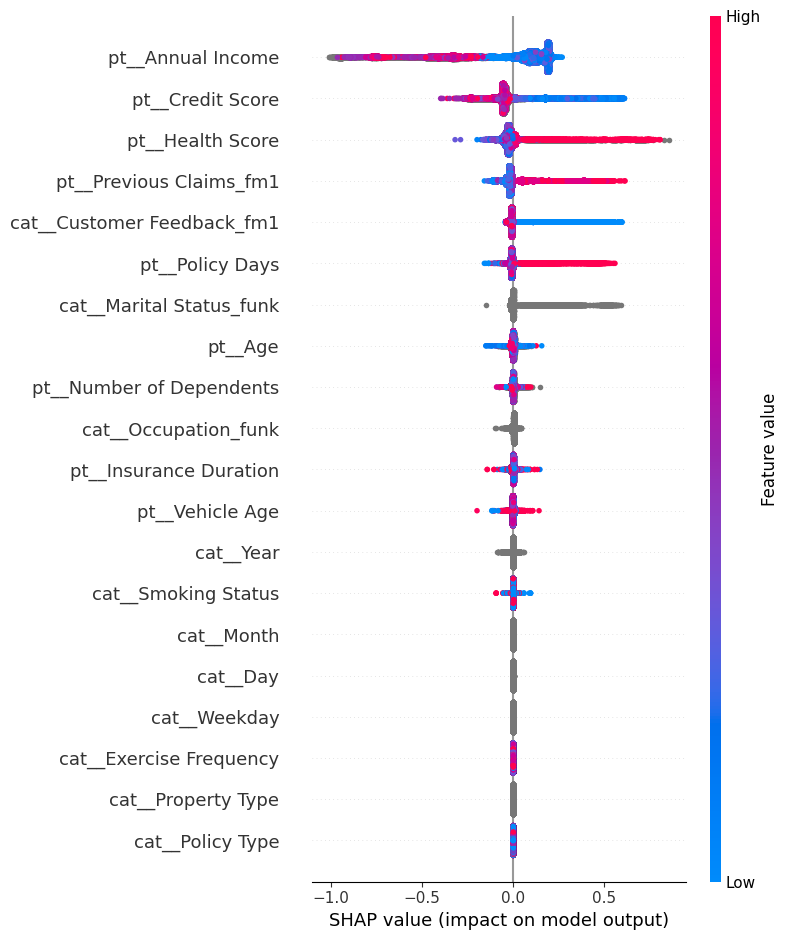

In [69]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

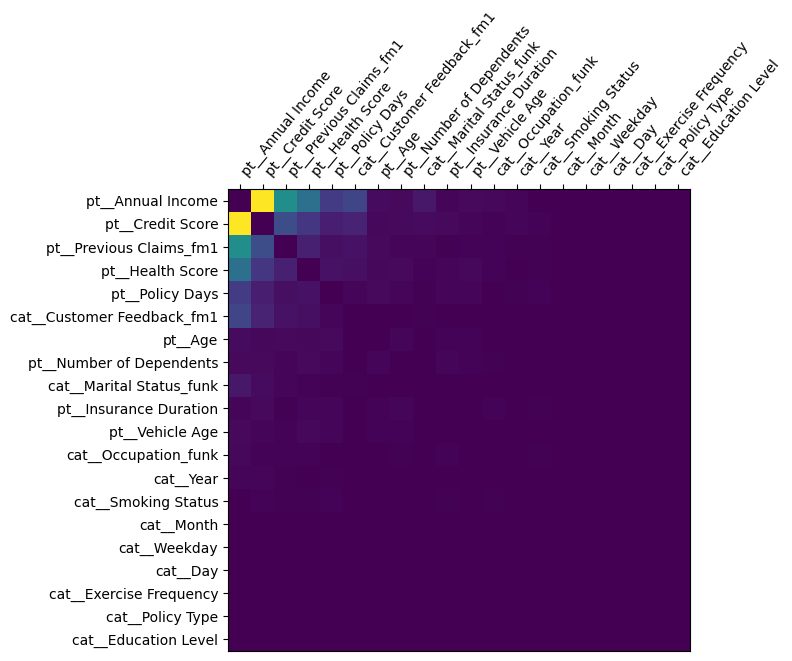

In [70]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

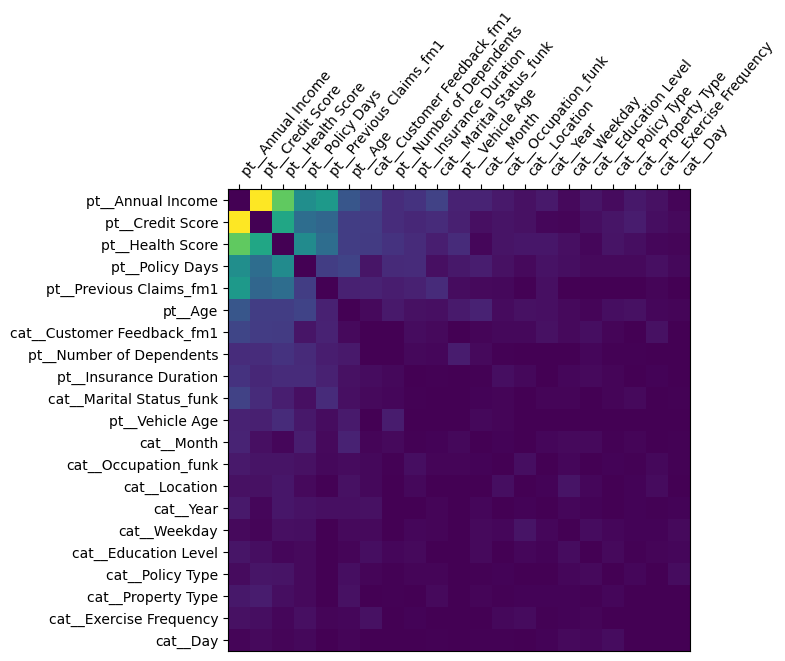

In [71]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

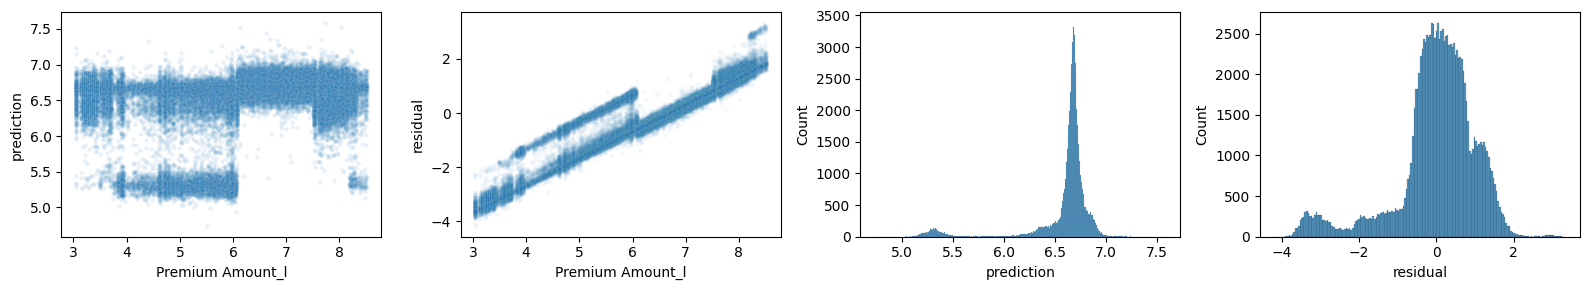

In [72]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

target이 4와 6 사이 그리고 8 이상인 구간에서ㅓ 예측값의 분포는 6.5 와 5.4 중심으로 나뉜다는 것을 알 수 있습니다. 이 현상을 살펴 봅니다.

In [73]:
df_valid[X_ord + ['Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Year  Marital Status_funk      Month  Location  \
stat    2.556413e+02         7.664362e+01  33.540731   4.68931   
pvalue  3.384937e-53         1.609852e-16   0.000430   0.09588   

        Education Level   Weekday    Gender        Day  Smoking Status  \
stat           4.115671  6.456851  0.493626  25.651847        0.135667   
pvalue         0.249242  0.374003  0.482314   0.692777        0.712627   

        Policy Type  Exercise Frequency  Property Type  Customer Feedback  \
stat       0.346107             0.81753       0.317257           0.053276   
pvalue     0.841093             0.84527       0.853313           0.973713   

        Occupation_funk  
stat           0.106414  
pvalue         0.991057

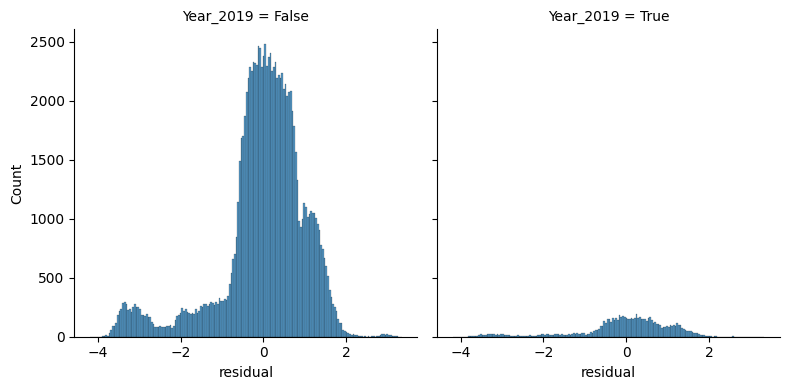

In [74]:
sns.displot(
    x=residual, col = df_valid['Year_2019'], height=4
)

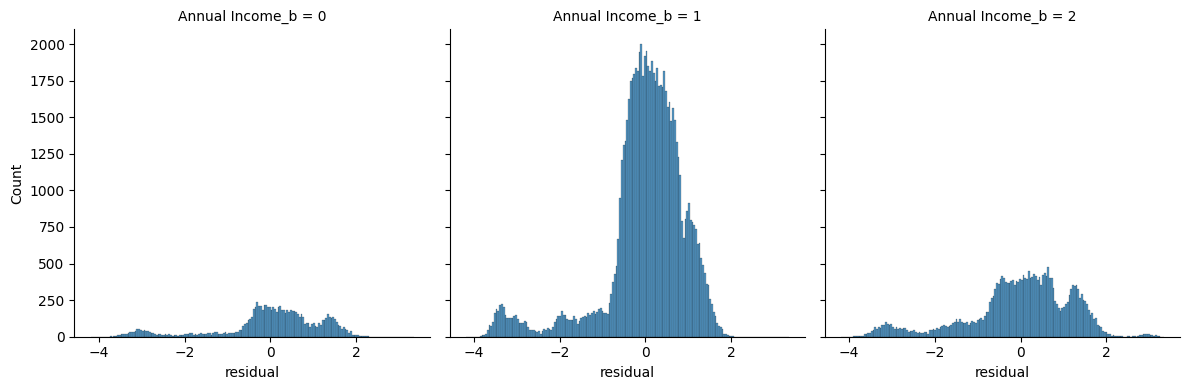

In [75]:
sns.displot(
    x=residual, col = df_valid['Annual Income_b'], height=4
)

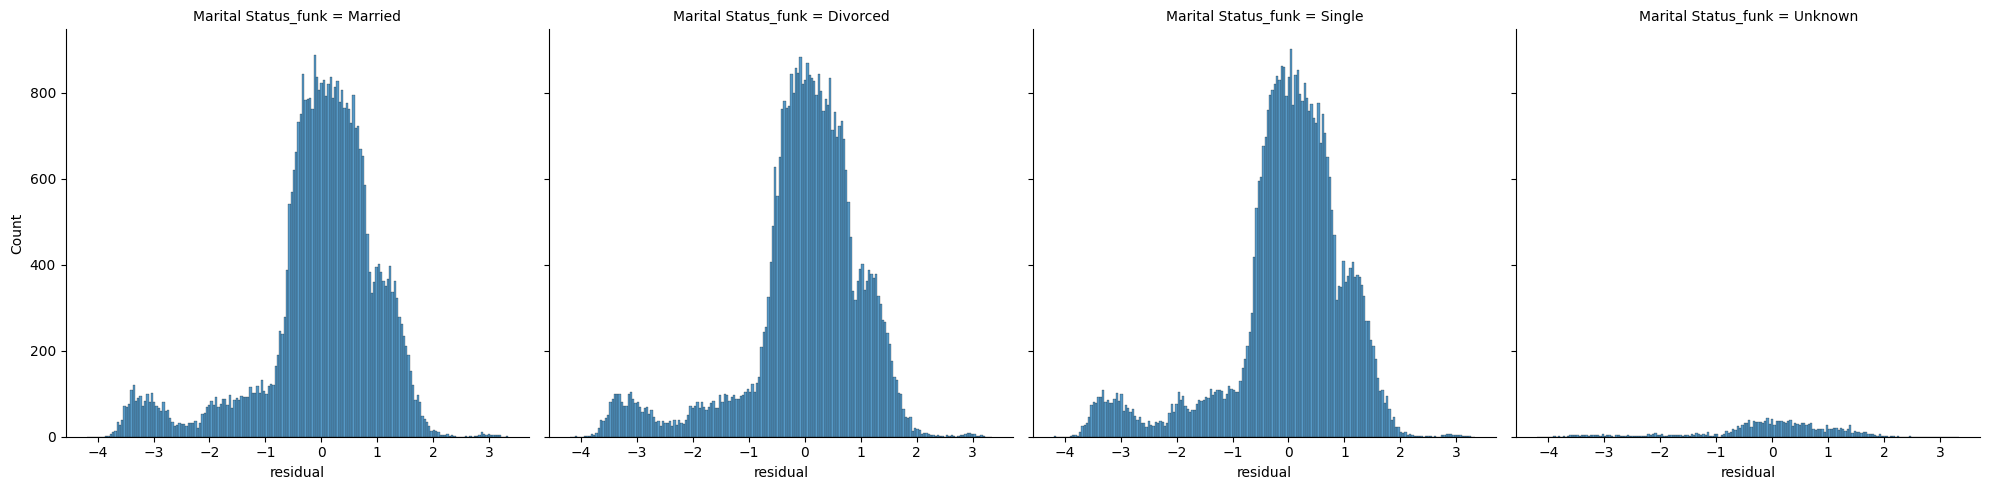

In [76]:
sns.displot(
    x=residual, col = df_valid['Marital Status_funk']
)

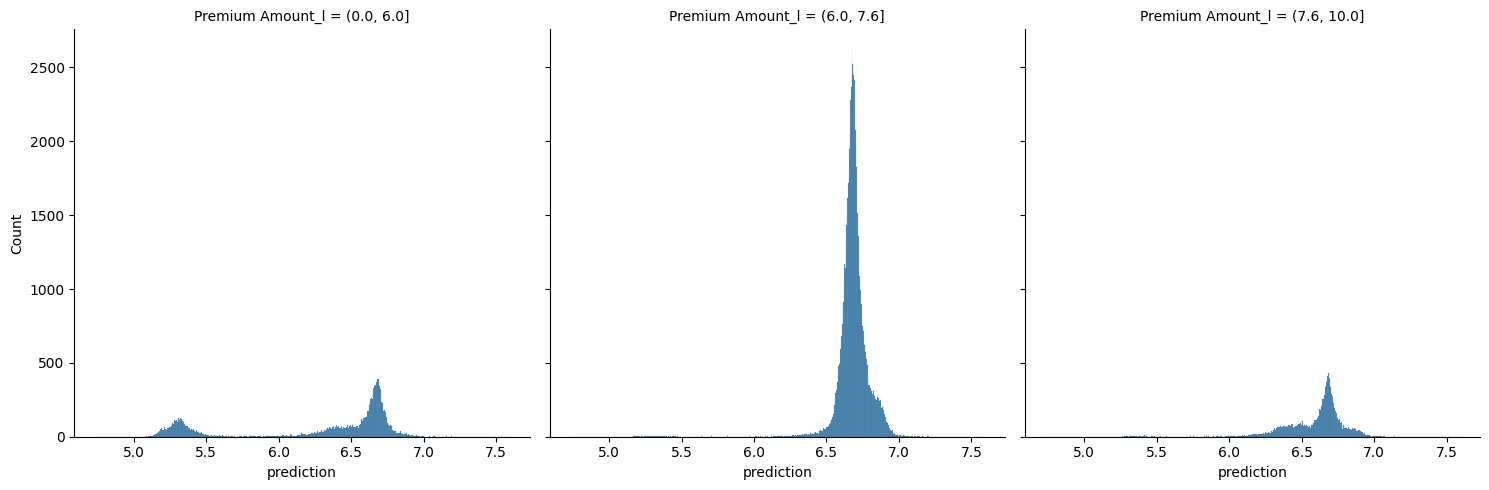

In [77]:
sns.displot(
    x=y_prd, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

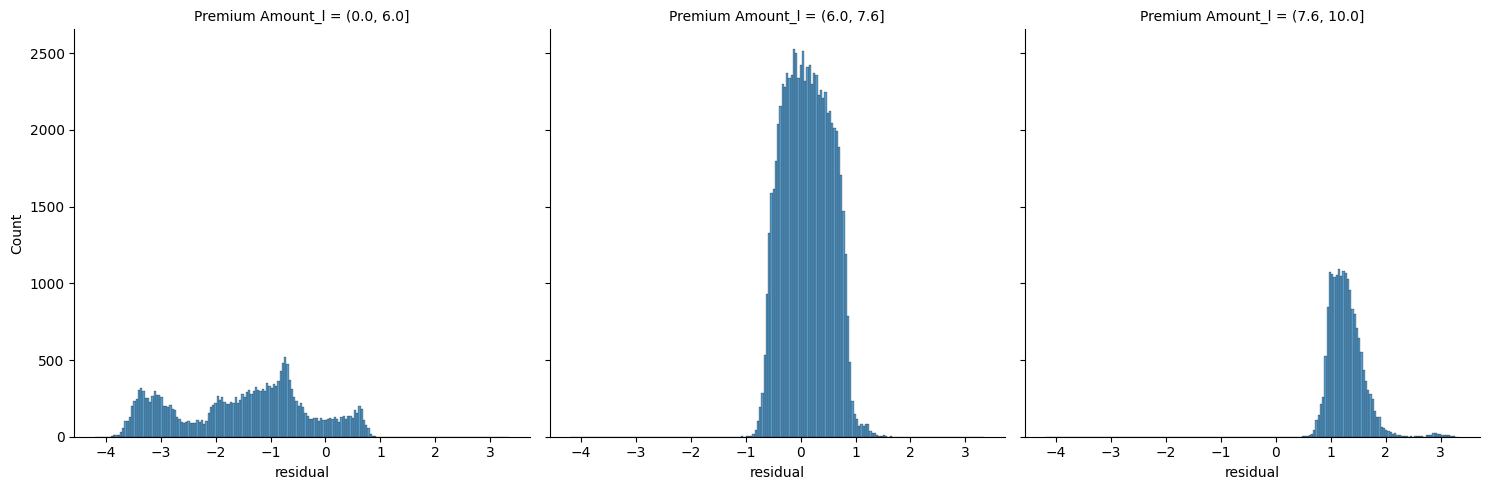

In [78]:
sns.displot(
    x=residual, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

target의 구간에 따라 잔차의 분포가 차이가 납니다. 잔차의 구간을 예측하는 모델을 만들어 봅니다. 

In [79]:
s_tgt_cnt_diff = s_tgt_cnt - s_tgt_cnt.rolling(100, center = True, min_periods = 1).mean()
df_train['density_diff'] = df_train['Premium Amount'].map(s_tgt_cnt_diff)
spearmanr(
    df_train.loc[residual.index, 'density_diff'], residual
)

SignificanceResult(statistic=-0.2532276392457791, pvalue=0.0)

In [80]:
kruskal(*df_train.groupby(df_train['Gender'], observed=True)['density_diff'].agg(lambda x: x.dropna().tolist()))

KruskalResult(statistic=1.254606258005251, pvalue=0.2626745271346594)

In [81]:
{
    i: kruskal(*df_train.groupby(df_train[i], observed=True)['density_diff'].agg(lambda x: x.dropna().tolist())).pvalue
    for i in X_cat
}

{'Gender': 0.2626745271346594,
 'Smoking Status': 0.0009875810807972694,
 'Education Level': 0.23939461824127556,
 'Location': 0.03875779952902194,
 'Policy Type': 0.099908611305737,
 'Exercise Frequency': 0.010918574639338393,
 'Customer Feedback': 0.23344295282933714,
 'Weekday': 0.14098938727636245,
 'Day': 0.0014013725092274678,
 'Year': 5.687929207110958e-17,
 'Month': 0.12638179531354227,
 'Marital Status': 0.03747851645338289,
 'Occupation': 0.4318667463901311,
 'Property Type': 0.7283751214091753}

In [82]:
pd.DataFrame({
    i: df_train[['density_diff', i]].dropna().pipe(lambda x: spearmanr(x['density_diff'], x[i]))
    for i in X_num
})

Age  Annual Income   Credit Score  Insurance Duration  Health Score  \
0 -0.001914      -0.042459   2.760006e-02           -0.000009  7.220780e-03   
1  0.037515       0.000000  4.906336e-178            0.992077  1.830179e-14   

   Number of Dependents  Previous Claims  Vehicle Age  
0             -0.001979     7.858700e-03     0.003133  
1              0.038822     6.699917e-13     0.000599

In [83]:
pd.DataFrame({
    i: df_train[['density_diff', i]].dropna().pipe(lambda x: spearmanr(x['density_diff'], x.groupby(i).transform('size')))
    for i in X_num
})

Age  Annual Income  Credit Score  Insurance Duration  Health Score  \
0 -0.002951       0.132558      0.065017           -0.004141     -0.139797   
1  0.001337       0.000000      0.000000            0.000006      0.000000   

   Number of Dependents  Previous Claims  Vehicle Age  
0             -0.003499    -7.858700e-03     0.000243  
1              0.000259     6.699917e-13     0.790323

In [84]:
s_vcnt_A = pd.concat([df_train['Annual Income'], df_test['Annual Income']]).value_counts()
s_vcnt_C = pd.concat([df_train['Credit Score'], df_test['Credit Score']]).value_counts()
s_vcnt_H = pd.concat([df_train['Health Score'], df_test['Health Score']]).value_counts()
df_train['Annual Income_Freq'] = df_train['Annual Income'].map(s_vcnt_A)
df_train['Credit Score_Freq'] = df_train['Credit Score'].map(s_vcnt_C)
df_train['Health Score_Freq'] = df_train['Health Score'].map(s_vcnt_H)

df_test['Annual Income_Freq'] = df_test['Annual Income'].map(s_vcnt_A)
df_test['Credit Score_Freq'] = df_test['Credit Score'].map(s_vcnt_C)
df_test['Health Score_Freq'] = df_test['Health Score'].map(s_vcnt_H)

df_train['Annual Income_Freqz'] = df_train['Annual Income_Freq'].fillna(0)
df_train['Credit Score_Freqz'] = df_train['Credit Score_Freq'].fillna(0)
df_train['Health Score_Freqz'] = df_train['Health Score_Freq'].fillna(0)

In [85]:
s_rvcnt_A2 = pd.Series(
    pd.concat([df_train['Annual Income'], df_test['Annual Income']]).value_counts(), index = pd.RangeIndex.from_range(range(1, 150000))
).fillna(0).rolling(30000, min_periods = 1, center = True).mean()
s_rvcnt_H2 = pd.Series(
    pd.concat([df_train['Health Score'], df_test['Health Score']]).value_counts()
).sort_index().rolling(1200, min_periods = 1, center = True).mean()

df_train['Annual Income_Freq_d'] = (df_train['Annual Income_Freq'] - df_train['Annual Income'].map(s_rvcnt_A2))
df_train['Health Score_Freq_d'] = (df_train['Health Score_Freq'] - df_train['Health Score'].map(s_rvcnt_H2))

df_test['Annual Income_Freq_d'] = (df_test['Annual Income_Freq'] - df_test['Annual Income'].map(s_rvcnt_A2))
df_test['Health Score_Freq_d'] = (df_test['Health Score_Freq'] - df_test['Health Score'].map(s_rvcnt_H2))

In [86]:
from scipy.stats import spearmanr
{
    i: df_train[['density_diff', i]].dropna().pipe(lambda x: spearmanr(x['density_diff'], x[i]))
    for i in ['Annual Income_Freq', 'Credit Score_Freq', 'Health Score_Freq', 'Annual Income_Freq_d', 'Health Score_Freq_d']
}

{'Annual Income_Freq': SignificanceResult(statistic=0.13282611043451203, pvalue=0.0),
 'Credit Score_Freq': SignificanceResult(statistic=0.06508341931919293, pvalue=0.0),
 'Health Score_Freq': SignificanceResult(statistic=-0.14170291310302952, pvalue=0.0),
 'Annual Income_Freq_d': SignificanceResult(statistic=0.14170851657038658, pvalue=0.0),
 'Health Score_Freq_d': SignificanceResult(statistic=-0.1429227096013082, pvalue=0.0)}

In [87]:
df_train[['Annual Income_Freq', 'Credit Score_Freq', 'Health Score_Freq', 'Annual Income_Freq_d', 'Health Score_Freq_d']].corr()

Annual Income_Freq  Credit Score_Freq  \
Annual Income_Freq              1.000000           0.106165   
Credit Score_Freq               0.106165           1.000000   
Health Score_Freq              -0.084832          -0.054845   
Annual Income_Freq_d            0.998509           0.104246   
Health Score_Freq_d            -0.086391          -0.055610   

                      Health Score_Freq  Annual Income_Freq_d  \
Annual Income_Freq            -0.084832              0.998509   
Credit Score_Freq             -0.054845              0.104246   
Health Score_Freq              1.000000             -0.085055   
Annual Income_Freq_d          -0.085055              1.000000   
Health Score_Freq_d            0.999644             -0.086597   

                      Health Score_Freq_d  
Annual Income_Freq              -0.086391  
Credit Score_Freq               -0.055610  
Health Score_Freq                0.999644  
Annual Income_Freq_d            -0.086597  
Health Score_Freq_d              1.000000

# ML org

<Axes: xlabel='Premium Amount_l', ylabel='Count'>

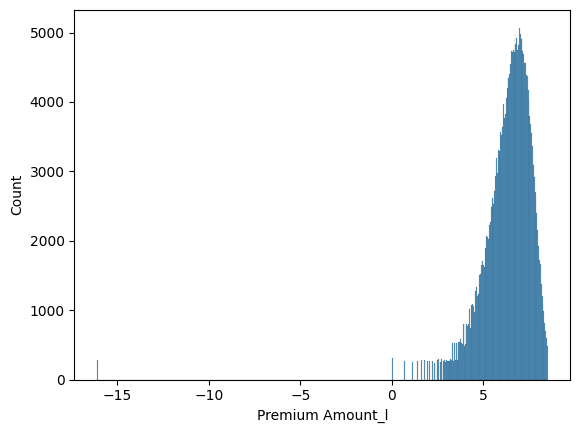

In [88]:
sns.histplot(df_org[target])

In [89]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 7},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_org', 
    lambda : sgml.cv(
        df_org.loc[df_org[target].notna()], ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.4512208840698364], [1.4465638739820983])

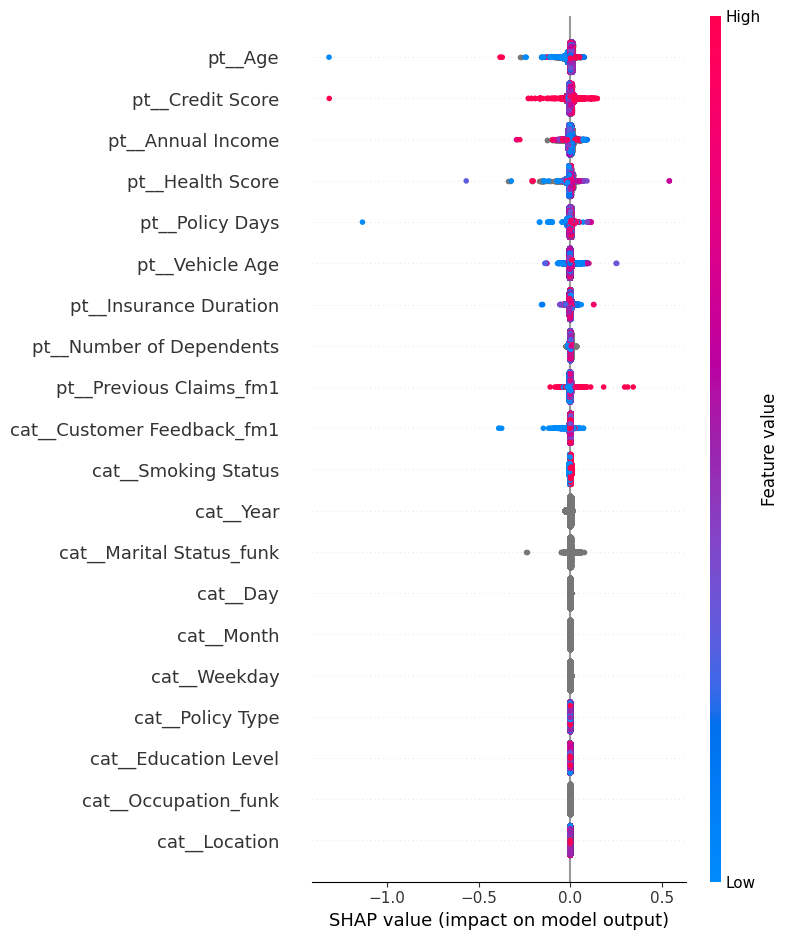

In [90]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

In [91]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
}
result = sc.cache_result(
    'cb_org2', 
    lambda : sgml.cv(
        df_org.loc[df_org[target].notna()], ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.4506679302685466], [1.4479438536850882])

In [92]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt_org',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_org.groupby(i, observed=True)[target].agg(lambda x: list(x.dropna()))), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = 0
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

Education Level  Exercise Frequency  Marital Status      Month  \
stat           6.366800            5.108199        3.092324  14.307860   
pvalue         0.095066            0.164044        0.213064   0.216424   

        Smoking Status      Year   Weekday  Property Type  Customer Feedback  \
stat          1.050151  5.751590  5.665861       1.159521           1.048889   
pvalue        0.305472  0.331146  0.461641       0.560033           0.591884   

        Policy Type  Occupation  Location    Gender        Day  
stat       0.909007    0.675901  0.510931  0.013815  20.278892  
pvalue     0.634763    0.713231  0.774556  0.906434   0.909077

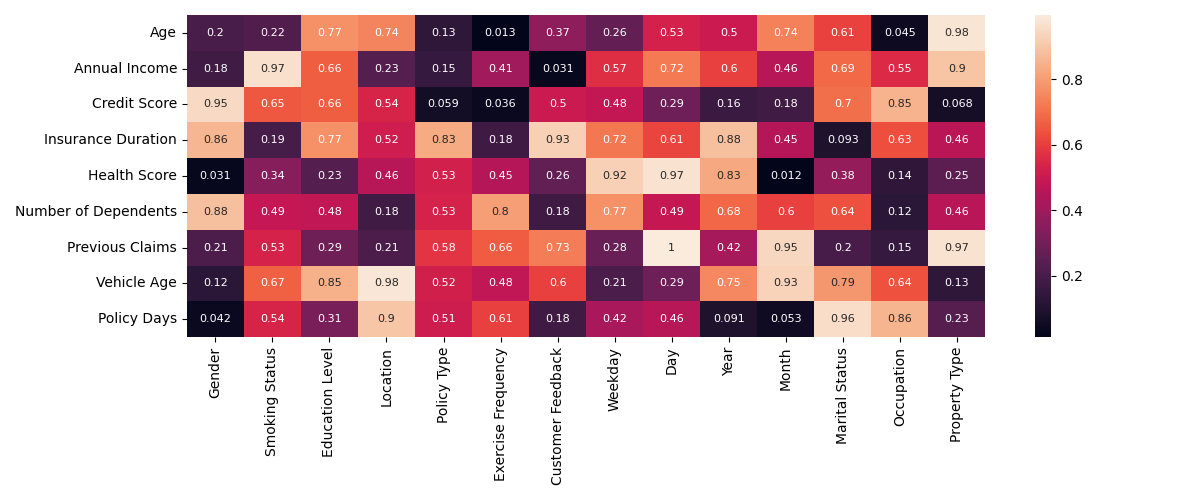

In [93]:
df_kruskal_cat_org = sc.cache_result('kruskal_cat_org', 
    lambda : pd.concat([
        df_org.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat_org',
    lambda x: sns.heatmap(
        df_kruskal_cat_org, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

In [94]:
df_spearman_target_org = sc.cache_result('spearman_target_org',
    lambda : pd.concat([
        pd.Series(
            df_org[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target_org

Credit Score       Age  Insurance Duration  Health Score  \
stat        0.003484  0.003040            0.002270      0.002311   
pvalue      0.081945  0.112671            0.232149      0.232885   

        Number of Dependents  Previous Claims  Annual Income  Vehicle Age  
stat                0.001161        -0.001070      -0.000757     0.000212  
pvalue              0.562124         0.635583       0.697882     0.911074

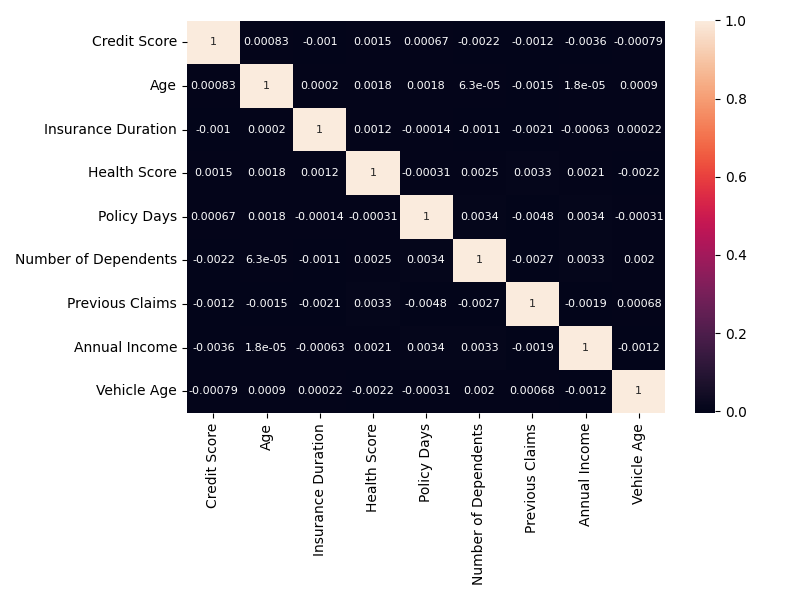

In [95]:
sc.cache_fig('spearman_between variables_org',
    lambda x: sns.heatmap(
        df_org[
            df_spearman_target_org.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

이 데이터셋의 기반이 되었던 원본 데이터셋을 조사해보니 ML 모델을 이용해서 Target을 예측하는 것은 의미도 없, 변수간의 상관성도 찾아볼 수 없는 

데이터셋으로 초보자가 연습삼아 만든 데이터셋으로 밖에 보이지 않습니다. 

# Missing Variable Imputation with ML

### Health Score

In [96]:
df_kruskal_cat.loc['Health Score'].sort_values().to_frame().T

Month           Day  Education Level    Gender  Location  \
Health Score  3.984273e-11  1.474154e-08         0.000002  0.000102  0.001243   

                  Year  Occupation  Property Type  Policy Type  \
Health Score  0.001639    0.005065       0.037185     0.048545   

              Exercise Frequency  Smoking Status  Marital Status  \
Health Score             0.04929        0.053193        0.104752   

              Customer Feedback   Weekday  
Health Score           0.353783  0.393192

In [97]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Health Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Number of Dependents  \
Health Score        0.02553      0.012016              0.005152   

              Insurance Duration  Previous Claims       Age  Vehicle Age  
Health Score            0.002487         0.001989  0.000881     0.000316

In [98]:
from sklearn.model_selection import cross_validate

X_H_cat = ['Year', 'Month', 'Education Level', 'Occupation', 'Gender', 'Location', 'Marital_Feedback', 'Smoking Status']
X_H_num = ['Annual Income', 'Credit Score', 'Annual Income_Freq', 'Credit Score_Freq', 'Annual Income_Freq_d'] 
clf_lgb = lgb.LGBMClassifier(
    n_estimators = 500, num_leaves = 63, learning_rate = 0.01,
    verbose = 0
)
sc.cache_result(
    'lgb_health_score',
    lambda :
        pd.concat([
                df_train.loc[df_train['Health Score'].notna()],
                df_test.loc[df_test['Health Score'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                clf_lgb, x[X_H_cat + X_H_num], x['Health Score'] >= 50, 
                scoring = 'roc_auc', cv = 5, 
                params = {'categorical_feature': X_H_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([10.05554175, 10.80923676, 11.12986565, 10.24046516, 10.19803977]),
 'score_time': array([1.77438354, 1.64432001, 1.66566563, 1.61506486, 1.98335147]),
 'test_score': array([0.69167693, 0.6914172 , 0.69546614, 0.69139538, 0.6908784 ]),
 'train_score': array([0.73814006, 0.74023394, 0.74130924, 0.7403611 , 0.74003436])}

In [99]:
clf_lgb = sc.cache_result(
    'lgb_health', 
    lambda : pd.concat([
                df_train.loc[df_train['Health Score'].notna()],
                df_test.loc[df_test['Health Score'].notna()]
            ]
        ).pipe(
            lambda x: clf_lgb.fit(x[X_H_cat + X_H_num], x['Health Score'] >= 50, categorical_feature = X_H_cat)
        ), rerun = 0
)
df_train['Health Score_50'] = np.where(df_train['Health Score'] >= 50, 1.0, 0.0)
df_test['Health Score_50'] = np.where(df_test['Health Score'] >= 50, 1.0, 0.0)
df_train.loc[df_train['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_train.loc[df_train['Health Score'].isna(), X_H_cat + X_H_num]
)[:, 1]
df_test.loc[df_test['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_test.loc[df_test['Health Score'].isna(), X_H_cat + X_H_num]
)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [100]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num + ['Health Score_50'], 'X_cat': X_ord3 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.047954055515193], [1.0453531296460103])

In [101]:
from scipy.stats import mannwhitneyu
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000157
Annual Income           0.002064
Previous Claims         0.007067
Age                     0.229833
Number of Dependents    0.452434
Customer Feedback       0.519371
Occupation              0.856055
Credit Score            0.903336
Marital Status          0.994174
dtype: float64

Regression 모델로 Health Score의 예측 정확도는 기대할 수 없지만, 시각화 그래프상에서 50 이상은 뚜렷하게 분포가 차이가 남을 알 수 있고, 

이를 바탕으로 50 이상 여부를 맞추는 모델은 어느 정도 성능을 기대할 수 있어 예측 결과를 사용한 결과 성능 효과를 볼 수 있었습니다.

### Annual Income

In [102]:
df_kruskal_cat.loc['Annual Income'].sort_values().to_frame().T

Year         Month  Exercise Frequency  Policy Type  \
Annual Income  1.499166e-82  1.203363e-07            0.001482     0.187004   

               Education Level  Smoking Status    Gender       Day  \
Annual Income         0.235417        0.250826  0.271901  0.308204   

               Occupation  Customer Feedback  Property Type   Weekday  \
Annual Income    0.362187           0.419487       0.504295  0.675542   

               Location  Marital Status  
Annual Income  0.773174        0.885622

In [103]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Annual Income'].abs().sort_values(ascending = False).iloc[1:].to_frame().T

Credit Score  Previous Claims  Health Score  \
Annual Income      0.201423         0.043065       0.02553   

               Number of Dependents  Vehicle Age  Insurance Duration       Age  
Annual Income              0.002135       0.0005            0.000379  0.000009

In [104]:
from sklearn.model_selection import cross_validate

X_A_cat = ['Marital_Feedback', 'Exercise Frequency', 'Year', 'Month', 'Occupation', 'Number of Dependents']
X_A_num = ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50', 'Credit Score_Freq', 'Health Score_Freq', 'Health Score_Freq_d']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, num_leaves = 63, learning_rate = 0.04, verbose = 0
)
sc.cache_result(
    'lgb_annual_income',
    lambda :
        pd.concat([
                df_train.loc[df_train['Annual Income'].notna()],
                df_test.loc[df_test['Annual Income'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_A_cat + X_A_num], x['Annual Income'],  scoring = 'r2', cv = 5, params = {'categorical_feature': X_A_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([7.3995471 , 8.37158751, 8.25336981, 8.42264748, 8.40957212]),
 'score_time': array([1.97405005, 1.70911717, 1.76168513, 1.6185658 , 1.67730308]),
 'test_score': array([0.13534445, 0.13510196, 0.13486943, 0.13020555, 0.13053464]),
 'train_score': array([0.14536042, 0.14540622, 0.14528292, 0.14681651, 0.14649605])}

In [105]:
reg_lgb = sc.cache_result(
    'lgb_annual_model', 
    lambda :pd.concat([
            df_train.loc[df_train['Annual Income'].notna()],
            df_test.loc[df_test['Annual Income'].notna()]
        ]
    ).pipe(
        lambda x: reg_lgb.fit(x[X_A_cat + X_A_num],  x['Annual Income'], categorical_feature = X_A_cat)
    ), rerun = 0
)
df_train['Annual Income_f'] = df_train['Annual Income']
df_test['Annual Income_f'] = df_test['Annual Income']
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_train.loc[df_train['Annual Income'].isna(), X_A_cat +  X_A_num]
).round().clip(1, 149997).astype('int')
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_test.loc[df_test['Annual Income'].isna(), X_A_cat +  X_A_num]
).round().clip(1, 149997).astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


Annual Income은 결측여부와 함께 보간한 Annual Income을 같이 쓰면 효과가 있습니다.

## Credit Score

In [106]:
df_kruskal_cat.loc['Credit Score'].sort_values().to_frame().T

Year  Education Level     Month  Marital Status  \
Credit Score  6.198969e-17         0.000376  0.000433        0.000556   

                   Day  Smoking Status  Location  Customer Feedback  \
Credit Score  0.038657        0.069232  0.122319           0.310679   

              Policy Type    Gender   Weekday  Property Type  Occupation  \
Credit Score      0.35527  0.433204  0.578883       0.593443    0.631712   

              Exercise Frequency  
Credit Score            0.665591

In [107]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Credit Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Previous Claims  Health Score       Age  Vehicle Age  \
Credit Score         0.036816      0.012016  0.002842     0.000508   

              Insurance Duration  Number of Dependents  Annual Income  
Credit Score            0.000493             -0.001714      -0.201423

In [108]:
from sklearn.model_selection import cross_validate

X_C_cat = ['Marital_Feedback', 'Occupation', 'Education Level', 'Year', 'Month', 'Gender', 'Location', 'Smoking Status', 'Property Type', 'Policy Type', 
           'Exercise Frequency', 'Number of Dependents']
X_C_num = ['Previous Claims', 'Health Score', 'Annual Income', 'Annual Income_f', 'Health Score_50', 'Annual Income_Freq', 'Health Score_Freq', 'Annual Income_Freq_d', 'Health Score_Freq_d']

reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, num_leaves = 63, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_credit_score',
    lambda :
        pd.concat([
                df_train.loc[df_train['Credit Score'].notna()],
                df_test.loc[df_test['Credit Score'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                reg_lgb,  x[X_C_cat + X_C_num],  x['Credit Score'],  scoring = 'r2', cv = 5,  params = {'categorical_feature': X_C_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([9.76870298, 9.82550907, 8.93109703, 8.76975775, 9.4593637 ]),
 'score_time': array([1.64260793, 1.67374086, 1.6825881 , 1.63171625, 1.64818907]),
 'test_score': array([0.17188079, 0.1726639 , 0.17239577, 0.16886405, 0.16778215]),
 'train_score': array([0.18412506, 0.18377819, 0.18348541, 0.18429438, 0.18489604])}

In [109]:
reg_lgb = sc.cache_result(
    'lgb_credit_score_prd', 
    lambda :pd.concat([
            df_train.loc[df_train['Credit Score'].notna()],
            df_test.loc[df_test['Credit Score'].notna()]
        ]
    ).pipe(
        lambda x: reg_lgb.fit(x[X_C_cat + X_C_num], x['Credit Score'], categorical_feature = X_C_cat)
    ), rerun = 0
)
df_train['Credit Score_f'] = df_train['Credit Score']
df_test['Credit Score_f'] = df_test['Credit Score']
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
    df_train.loc[df_train['Credit Score'].isna(), X_C_cat + X_C_num]
).clip(300, 849).astype('int')
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
    df_test.loc[df_test['Credit Score'].isna(), X_C_cat + X_C_num]
).clip(300, 849).astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


## Previous Claims

In [110]:
df_kruskal_cat.loc['Previous Claims'].sort_values().to_frame().T

Year  Policy Type  Property Type   Weekday       Day  \
Previous Claims  5.431242e-17     0.020671        0.03072  0.035647  0.041818   

                 Customer Feedback  Education Level     Month  Marital Status  \
Previous Claims           0.046106         0.056846  0.077654        0.086356   

                 Smoking Status  Location  Exercise Frequency    Gender  \
Previous Claims        0.086622  0.321809            0.375611  0.882875   

                 Occupation  
Previous Claims    0.946917

In [111]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Previous Claims'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Insurance Duration  \
Previous Claims       0.043065      0.036816            0.003001   

                 Health Score       Age  Vehicle Age  Number of Dependents  
Previous Claims      0.001989  0.001869    -0.001172             -0.004123

In [112]:
from sklearn.model_selection import cross_validate

X_PC_cat = ['Year', 'Policy Type', 'Property Type', 'Marital_Feedback', 'Weekday', 'Occupation', 'Gender', 'Smoking Status', 'Education Level']
X_PC_num = ['Credit Score', 'Credit Score_f','Annual Income', 'Annual Income_f', 'Annual Income_Freq', 'Credit Score_Freq', 'Health Score_Freq', 
            'Annual Income_Freq_d', 'Health Score_Freq_d', 'Health Score', 'Health Score_50', 'Vehicle Age', 'Number of Dependents']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, num_leaves = 63, learning_rate = 0.04, 
    verbose = 0
)
sc.cache_result(
    'lgb_previous_claims',
    lambda :
        pd.concat([
            df_train.loc[df_train['Previous Claims'].notna()],
            df_test.loc[df_test['Previous Claims'].notna()]
        ]).pipe(
            lambda x: cross_validate(
                reg_lgb,  x[X_PC_cat + X_PC_num],  x['Previous Claims'].clip(0, 6),  scoring = 'r2', cv = 5,  
                params = {'categorical_feature': X_PC_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([8.04336262, 7.35737157, 7.42071724, 8.62410188, 7.14787626]),
 'score_time': array([1.20657468, 1.49224353, 1.21572399, 1.19507074, 1.20238066]),
 'test_score': array([0.09590547, 0.09731918, 0.09610509, 0.09560519, 0.09549608]),
 'train_score': array([0.11166965, 0.11134024, 0.11187925, 0.11181443, 0.11231103])}

In [113]:
reg_lgb = sc.cache_result(
    'lgb_previous_claims_model', 
    lambda :pd.concat([
            df_train.loc[df_train['Previous Claims'].notna()],
            df_test.loc[df_test['Previous Claims'].notna()]
    ]).pipe(
        lambda x: reg_lgb.fit(x[X_PC_cat + X_PC_num],  x['Previous Claims'].clip(0, 6), categorical_feature = X_PC_cat)
    ), rerun = 0
)
df_train['Previous Claims_f'] = df_train['Previous Claims']
df_test['Previous Claims_f'] = df_test['Previous Claims']
df_train.loc[df_train['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_train.loc[df_train['Previous Claims'].isna(), X_PC_cat +  X_PC_num]
).clip(0, 6).astype('float32')
df_test.loc[df_test['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_test.loc[df_test['Previous Claims'].isna(), X_PC_cat + X_PC_num]
).clip(0, 6).astype('float32')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


## Iterative

In [114]:
from sklearn.model_selection import cross_val_score

def iterative_imp(it, skip_val = True):
    for i in range(it):
        clf_lgb = lgb.LGBMClassifier(n_estimators = 500, num_leaves = 63, learning_rate = 0.01, verbose = 0)
        score_H, clf_lgb = pd.concat([
                df_train.loc[df_train['Health Score'].notna()],
                df_test.loc[df_test['Health Score'].notna()]
            ]
        ).pipe(
            lambda x: (
                cross_val_score(
                    clf_lgb, x[X_H_cat + X_H_num + ['Credit Score_f', 'Annual Income_f', 'Previous Claims_f']], x['Health Score'] >= 50, 
                    scoring = 'roc_auc', cv = ss, 
                    params = {'categorical_feature': X_H_cat}
                ) if not skip_val else 'skip',
                clf_lgb.fit(x[X_H_cat + X_H_num + ['Credit Score_f', 'Annual Income_f', 'Previous Claims_f']], x['Health Score'] >= 50, categorical_feature = X_H_cat)
            )
        )
        df_train.loc[df_train['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
            df_train.loc[df_train['Health Score'].isna(), X_H_cat + X_H_num + ['Credit Score_f', 'Annual Income_f', 'Previous Claims_f']]
        )[:, 1]
        df_test.loc[df_test['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
            df_test.loc[df_test['Health Score'].isna(), X_H_cat + X_H_num + ['Credit Score_f', 'Annual Income_f', 'Previous Claims_f']]
        )[:, 1]
        
        reg_lgb = lgb.LGBMRegressor(n_estimators = 500, num_leaves = 63, learning_rate = 0.04, verbose = 0)
        
        score_A, reg_lgb = pd.concat([
                df_train.loc[df_train['Annual Income'].notna()],
                df_test.loc[df_test['Annual Income'].notna()]
            ]
        ).pipe(
            lambda x: (
                cross_val_score(
                    reg_lgb,  x[X_A_cat + X_A_num + ['Credit Score_f', 'Previous Claims_f']],  x['Annual Income'],  scoring = 'r2', cv = ss,  params = {'categorical_feature': X_A_cat}
                ) if not skip_val else 'skip',
                reg_lgb.fit(x[X_A_cat + X_A_num + ['Credit Score_f', 'Previous Claims_f']],  x['Annual Income'], categorical_feature = X_A_cat)
            )
        )
        
        df_train.loc[df_train['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
            df_train.loc[df_train['Annual Income'].isna(), X_A_cat +  X_A_num + ['Credit Score_f', 'Previous Claims_f']]
        ).clip(1, 149997).round().astype('int')
        df_test.loc[df_test['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
            df_test.loc[df_test['Annual Income'].isna(), X_A_cat +  X_A_num + ['Credit Score_f', 'Previous Claims_f']]
        ).clip(1, 149997).round().astype('int')
        
        reg_lgb = lgb.LGBMRegressor(
            n_estimators = 500, num_leaves = 63, learning_rate = 0.05,
            verbose = 0
        )
        score_C, reg_lgb = pd.concat([
                df_train.loc[df_train['Credit Score'].notna()],
                df_test.loc[df_test['Credit Score'].notna()]
            ]
        ).pipe(
            lambda x: (
                cross_val_score(
                    reg_lgb,  x[X_C_cat + X_C_num + ['Previous Claims_f']],  x['Credit Score'],  scoring = 'r2', cv = ss,  params = {'categorical_feature': X_C_cat}
                ) if not skip_val else 'skip',
                reg_lgb.fit(x[X_C_cat + X_C_num + ['Previous Claims_f']], x['Credit Score'], categorical_feature = X_C_cat)
            )
        )
        
        df_train.loc[df_train['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
            df_train.loc[df_train['Credit Score'].isna(), X_C_cat + X_C_num + ['Previous Claims_f']]
        ).clip(300, 849).astype('int')
        df_test.loc[df_test['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
            df_test.loc[df_test['Credit Score'].isna(), X_C_cat + X_C_num + ['Previous Claims_f']]
        ).clip(300, 849).astype('int')

        reg_lgb = lgb.LGBMRegressor(n_estimators = 500, num_leaves = 63, learning_rate = 0.04, verbose = 0)        
        score_PC, reg_lgb = pd.concat([
            df_train.loc[df_train['Previous Claims'].notna()],
            df_test.loc[df_test['Previous Claims'].notna()]
        ]).pipe(
            lambda x: (
                cross_val_score(
                    reg_lgb,  x[X_PC_cat + X_PC_num],  x['Previous Claims'].clip(0, 6),  scoring = 'r2', cv = ss,  params = {'categorical_feature': X_PC_cat}
                ) if not skip_val else 'skip',
                reg_lgb.fit(x[X_PC_cat + X_PC_num],  x['Previous Claims'].clip(0, 6), categorical_feature = X_PC_cat)
            )
        )
        df_train.loc[df_train['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
            df_train.loc[df_train['Previous Claims'].isna(), X_PC_cat +  X_PC_num]
        ).clip(0, 6).astype('float32')
        df_test.loc[df_test['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
            df_test.loc[df_test['Previous Claims'].isna(), X_PC_cat + X_PC_num]
        ).clip(0, 6).astype('float32')

        print(i + 1, score_H, score_A, score_C, score_PC)
    return (
        df_train[['Health Score_50', 'Annual Income_f', 'Credit Score_f', 'Previous Claims_f']],
        df_test[['Health Score_50', 'Annual Income_f', 'Credit Score_f', 'Previous Claims_f']]
    )

df_train_f, df_test_f = sc.cache_result(
    'iterative_f',
    lambda : iterative_imp(2, False), rerun=0
)
df_train = dproc.join_and_assign(df_train, df_train_f)
df_test = dproc.join_and_assign(df_test, df_test_f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
1 [0.76550743] [0.26160862] [0.25510589] [0.13589448]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace wi

# Binning & Target Encoding

In [115]:
def get_bin_proc(df):
    A_bins = np.linspace(*df['Annual Income'].agg(['min', 'max']), 26)
    A_bins[[0, -1]] = [-np.inf, np.inf]
    C_bins = np.linspace(*df['Credit Score'].agg(['min', 'max']), 10)
    C_bins[[0, -1]] = [-np.inf, np.inf]
    H_bins = np.linspace(*df['Health Score'].agg(['min', 'max']), 5)
    H_bins[[0, -1]] = [-np.inf, np.inf]
    
    c_type_a = pd.CategoricalDtype(['NA'] + pd.cut(df['Annual Income'], bins = A_bins).cat.categories.tolist())
    c_type_c = pd.CategoricalDtype(['NA'] + pd.cut(df['Credit Score'], bins = C_bins).cat.categories.tolist())
    c_type_h = pd.CategoricalDtype(['NA'] + pd.cut(df['Health Score'], bins = H_bins).cat.categories.tolist())
    
    c_type_a2 = pd.CategoricalDtype(pd.cut(df['Annual Income_f'], bins = A_bins).cat.categories.map(str))
    c_type_c2 = pd.CategoricalDtype(pd.cut(df['Credit Score_f'], bins = C_bins).cat.categories.map(str))
    
    def bin_proc(x):
        df = pd.concat([
            dproc.replace_cat(pd.cut(x['Annual Income'], bins = A_bins).astype(c_type_a).fillna('NA'), lambda x: str(x)).rename('Annual Income_R'),
            dproc.replace_cat(pd.cut(x['Credit Score'], bins = C_bins).astype(c_type_c).fillna('NA'), lambda x: str(x)).rename('Credit Score_R'),
            dproc.replace_cat(pd.cut(x['Health Score'], bins = H_bins).astype(c_type_h).fillna('NA'), lambda x: str(x)).rename('Health Score_R'),
            dproc.replace_cat(pd.cut(x['Annual Income_f'], bins = A_bins), lambda x: str(x)).astype(c_type_a2).rename('Annual Income_R2'),
            dproc.replace_cat(pd.cut(x['Credit Score_f'], bins = C_bins), lambda x: str(x)).astype(c_type_c2).rename('Credit Score_R2')
        ], axis=1)
        return pd.concat(
            [df] + [
                dproc.combine_cat(df[['Credit Score_R', 'Annual Income_R']], '_').rename('CA'),
                dproc.combine_cat(df[['Annual Income_R', 'Health Score_R']], '_').rename('AH'),
                dproc.combine_cat(df[['Health Score_R', 'Credit Score_R']], '_').rename('CH'),
                dproc.combine_cat(df[['Credit Score_R2', 'Annual Income_R2']], '_').rename('CA2'),
            ], axis=1)
    return bin_proc
bin_proc = get_bin_proc(df_train)
df_train = pd_vars.put_proc('r_proc', df_train, [
    (bin_proc, {
        'Annual Income_R': 'Annual Income을 25개의 등간격 구간화.',
        'Credit Score_R': 'Credit Score를 10개의 등간격 구간화.',
        'Health Score_R': 'Health Score를 5개의 등간격 구간화.',
        'Annual Income_R2': 'Annual Income_f를 25개의 등간격 구간화.',
        'Credit Score_R2': 'Credit Score_f를 10개의 등간격 구간화.',
        'CA': 'Credit Score_R과 Annual Income_R를 조합',
        'AH': 'Annual Income_R과 Health Score_R을 조합',
        'CH': 'Credit Score_R과 Health Score_R을 조합',
        'CA2': 'Credit Score_R2과 Annual Income_R2를 조합',
    })
])
df_test = dproc.join_and_assign(df_test, pd_vars.proc('r_proc', df_test))

In [116]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
kf = KFold(5, random_state=123, shuffle=True)

def tgt_encoding():
    val = ['AH', 'CA', 'CH', 'CA2', 'Credit Score_R', 'Annual Income_R', 'Health Score_R', 'Credit Score_R2', 'Annual Income_R2']
    kf_dic = {i: list() for i in val}
    tgt = TargetEncoder()
    for train_idx, test_idx in kf.split(df_train, df_train[target]):
        df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
        for i in val:
            tgt.fit(df_cv_train[[i]], df_cv_train[target])
            #print(i, mean_squared_error(df_valid[target], tgt.transform(df_valid[[i]]))  ** 0.5)
            kf_dic[i].append(
                pd.Series(tgt.transform(df_valid[[i]])[:, 0], index = df_valid.index, name = i)
            )
    
    return pd.concat([pd.concat(v, axis=0) for k, v in kf_dic.items()], axis=1).pipe(
        lambda x: pd.concat([
            (x['CA'] - x['Credit Score_R']).rename('CA_C'),
            (x['CA'] - x['Annual Income_R']).rename('CA_A'),
            (x['AH'] - x['Annual Income_R']).rename('AH_A'),
            (x['AH'] - x['Health Score_R']).rename('AH_H'),
            (x['CH'] - x['Health Score_R']).rename('CH_H'),
            (x['CH'] - x['Credit Score_R']).rename('CH_C'),
            (x['CA2'] - x['Credit Score_R2']).rename('CA_C2'),
            (x['CA2'] - x['Annual Income_R2']).rename('CA_A2')
        ], axis=1)
    )

df_train = dproc.join_and_assign(
    df_train, sc.cache_result('tgt_encodiing_train', tgt_encoding, rerun=0)
)

In [118]:
def tgt_encoding_test():
    val = ['AH', 'CA', 'CH', 'CA2', 'Credit Score_R', 'Annual Income_R', 'Health Score_R', 'Credit Score_R2', 'Annual Income_R2']
    tgt = TargetEncoder()
    return pd.concat([
        pd.Series(tgt.fit(df_train[[i]], df_train[target]).transform(df_test[[i]])[:, 0], index = df_test.index, name = i) for i in val
    ], axis=1).pipe(
        lambda x: pd.concat([
            (x['CA'] - x['Credit Score_R']).rename('CA_C'),
            (x['CA'] - x['Annual Income_R']).rename('CA_A'),
            (x['AH'] - x['Annual Income_R']).rename('AH_A'),
            (x['AH'] - x['Health Score_R']).rename('AH_H'),
            (x['CH'] - x['Health Score_R']).rename('CH_H'),
            (x['CH'] - x['Credit Score_R']).rename('CH_C'),
            (x['CA2'] - x['Credit Score_R2']).rename('CA_C2'),
            (x['CA2'] - x['Annual Income_R2']).rename('CA_A2')
        ], axis=1)
    )

df_test = dproc.join_and_assign(
    df_test, sc.cache_result('tgt_encodiing_test', tgt_encoding_test, rerun=0)
)

# Using Classification

## 3-class

target이 6 ~ 7.6 사이에 밀집해 있습니다. 이를 중심으로 분포의 우측과 좌측으로 분리해봅니다.

In [148]:
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error
ss = ShuffleSplit(1, random_state=123)
skf = StratifiedKFold(5, random_state = 123, shuffle = True)

df_train['target_2'] =  pd.cut(df_train[target], [-np.inf, 6, np.inf], labels = [0, 1])
df_train['target_3'] =  pd.cut(df_train[target], [-np.inf, 6, 7.6, np.inf], labels = [0, 1, 2])
df_train['target_5'] =  pd.cut(df_train[target], [-np.inf, 4, 5, 6, 7.6, np.inf], labels = [0, 1, 2, 3, 4])

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config_2 = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prds: accuracy_score(df['target_3'].sort_index(), prds.idxmax(axis=1).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'target_3',
}

config_3 = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prds: accuracy_score(df['target_5'].sort_index(), prds.idxmax(axis=1).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'target_5',
}

config_4 = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prds: roc_auc_score(df['target_2'].sort_index(), prds.idxmax(axis=1).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'target_2',
}

cb_adapter_c = sgml.CBAdapter(cb.CatBoostClassifier)
lgb_adapter_c = sgml.LGBMAdapter(lgb.LGBMClassifier)

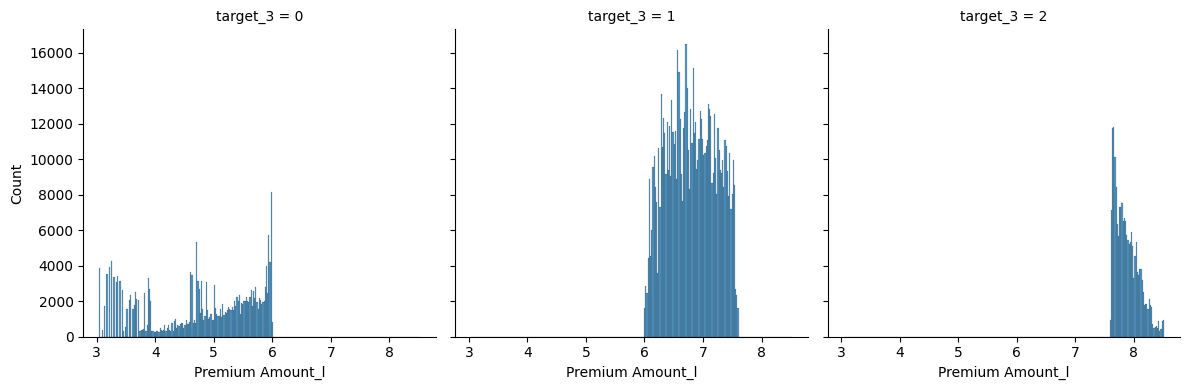

In [120]:
sns.displot(x = df_train[target], col = df_train['target_3'], height=4)

In [121]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05},
    'X_num':  X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'CA_C2', 'CA_A2', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Occupation_funk', 'Property Type', 'Marital_Feedback'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_2, cb_adapter_c, 
        result_proc = [sgml.cb_learning_result,  cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([0.7455833333333334], [0.7443851851851851])

In [122]:
df_train['target_3'].value_counts(normalize=True)

target_3
1    0.653996
0    0.188366
2    0.157638
Name: proportion, dtype: float64

In [123]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False).iloc[:15]

pt__CA_C                   12.415906
pt__Previous Claims_fm1    11.314595
pt__Annual Income          10.186861
pt__Annual Income_f         9.433401
cat__Marital_Feedback       8.300611
pt__Credit Score_f          7.685537
pt__Health Score_50         7.621454
pt__CA_A                    4.927772
pt__AH_H                    3.097497
pt__Health Score_Freq       2.835472
pt__CH_H                    2.709886
pt__Credit Score            2.709869
pt__Health Score_Freq_d     2.663225
pt__Previous Claims_f       2.509022
pt__Annual Income_Freq      2.464009
dtype: float64

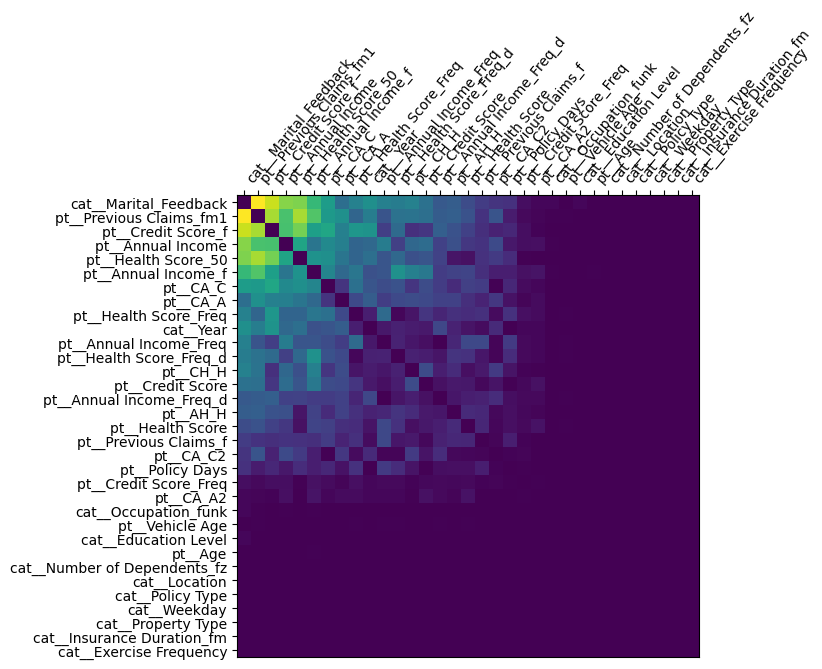

In [124]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

In [125]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H','Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb1_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_2, lgb_adapter_c, 
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([0.7466166666666667], [0.7515583333333333])

In [126]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb1_c5', 
    lambda : sgml.cv(
        df_train, skf, hparams, {**config_2, 'return_train_scores': False}, lgb_adapter_c, 
    ), rerun=0
)

df_train = dproc.join_and_assign(
    df_train,
    result['valid_prd'].rename(columns = lambda x: 't{}'.format(x))
)
result['valid_scores']

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.7447458333333333,
 0.7457333333333334,
 0.7465208333333333,
 0.7460458333333333,
 0.7457791666666667]

In [127]:
confusion_matrix(df_train['target_3'].sort_index(), result['valid_prd'].idxmax(axis=1).sort_index())

array([[ 84344, 116904,  24791],
       [  8159, 770561,   6075],
       [ 24264, 124889,  40013]])

In [128]:
df_train['target_3'].value_counts().sort_index()

target_3
0    226039
1    784795
2    189166
Name: count, dtype: int64

In [129]:
df_train = pd_vars.put_proc(
    'fl', df_train, 
    [(lambda x: np.log(x['Annual Income_f'] + 1).rename('Annual Income_fl'), 'Annual Income_f를 로그 변환합니다')], 1
)
df_test = dproc.join_and_assign(df_test, pd_vars.proc('fl', df_test))

In [130]:
hparams = {
    'X_mm': ['Previous Claims_f', 'Credit Score_f', 'Annual Income_fl', 'Annual Income_Freqz', 'Credit Score_Freqz', 'Health Score_Freqz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_isna', 'Health Score_50', 'CA_C', 'CA_A', 'CH_H', 'AH_H'] + ['t0', 't1'],
    'X_ohe': ['Marital_Feedback'], 'ohe': {'drop': 'first'},
}
result = sgml.cv(df_train, ss, hparams, config, lr_adapter)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([1.0418297526686056], [1.0411503043830548])

In [131]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 't0', 't1', 't2', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb3', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([1.0408751402968415], [1.0370272066688233])

In [132]:
result['model_result'][0]['feature_importance'].sort_values(ascending = False).iloc[:20]

pt__t0                          41.235864
pt__t2                          10.272389
pt__t1                           4.190702
pt__Health Score_Freq_d          3.703122
pt__Health Score_Freq            3.118814
pt__Annual Income                2.565166
pt__Credit Score_Freq            2.253435
pt__Credit Score_f               2.174504
pt__Annual Income_f              2.170950
pt__Health Score                 2.129219
cat__Year                        2.077443
pt__Age                          1.898270
pt__CH_H                         1.891182
pt__Vehicle Age                  1.702526
pt__AH_H                         1.691799
pt__CA_A                         1.573119
pt__Annual Income_Freq           1.561243
pt__Annual Income_Freq_d         1.527453
cat__Number of Dependents_fz     1.422355
pt__Previous Claims_fm1          1.382585
dtype: float64

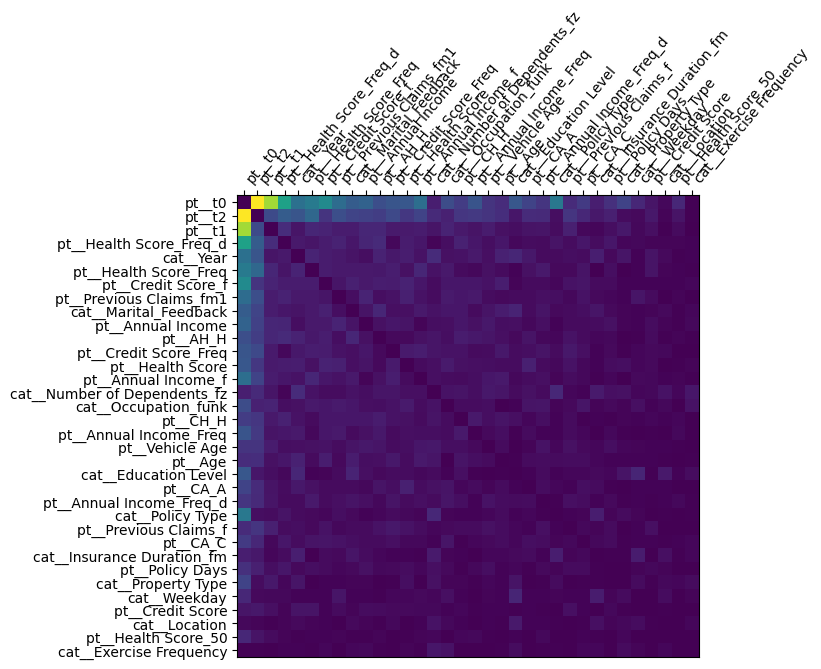

In [133]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

In [134]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 31, 'learning_rate': 0.05, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'],
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool , 
    'random_state': 123,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb1_2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, lgb_adapter, 
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([1.0421398831114994], [1.026538352751632])

In [135]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 31, 'learning_rate': 0.02, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d']+ ['t0', 't1', 't2'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback'] + X_bool , 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb1', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, lgb_adapter, 
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([1.0410506646071636], [1.031565623346519])

## Residual Analysis 

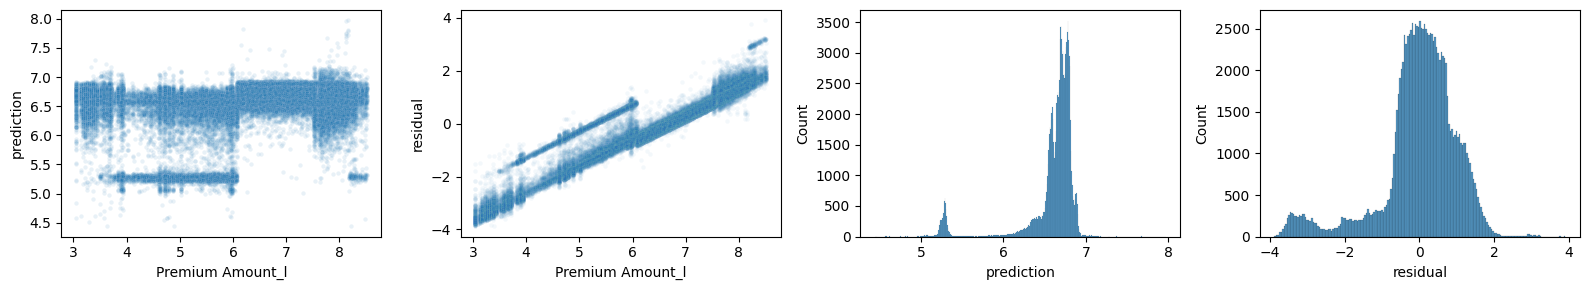

In [136]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

## 5-Class

In [139]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb2_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_3, lgb_adapter_c, 
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([0.7235333333333334], [0.7277472222222222])

In [141]:
(
    accuracy_score(df_train['target_5'].loc[result['valid_prd'].index], result['valid_prd'].idxmax(axis=1)),
    confusion_matrix(df_train['target_5'].loc[result['valid_prd'].index], result['valid_prd'].idxmax(axis=1))
)

(0.7235333333333334,
 array([[   36,    62,   549,  3794,  2024],
        [   18,   170,  1753,  2579,   983],
        [   13,    86,  3457,  5316,  1810],
        [    1,    19,   345, 77159,  1045],
        [   14,    24,   327, 12414,  6002]]))

In [142]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb2_c5', 
    lambda : sgml.cv(
        df_train, skf, hparams, {**config_3, 'return_train_scores': False}, lgb_adapter_c, 
    ), rerun=0
)
result['valid_scores']

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.7229875,
 0.7228666666666667,
 0.7234708333333333,
 0.7232833333333333,
 0.7222375]

In [143]:
df_train = dproc.join_and_assign(
    df_train,
    result['valid_prd'].rename(columns = lambda x: 't5_{}'.format(x))
)

In [144]:
df_train['target_5'].value_counts(normalize=True)

target_5
3    0.653996
4    0.157638
2    0.089300
0    0.053058
1    0.046007
Name: proportion, dtype: float64

In [145]:
hparams = {
    'X_mm': ['Previous Claims_f', 'Credit Score_f', 'Annual Income_fl', 'Annual Income_Freqz', 'Credit Score_Freqz', 'Health Score_Freqz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_isna', 'Health Score_50', 'CA_C', 'CA_A', 'CH_H', 'AH_H'] + \
            ['t0', 't1', 't5_0', 't5_1', 't5_2', 't5_3'],
    'X_ohe': ['Marital_Feedback'], 'ohe': {'drop': 'first'},
}
result = sgml.cv(df_train, ss, hparams, config, lr_adapter)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([1.0407612807481033], [1.040238088577072])

In [147]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.01, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d']+ \
                        ['t0', 't1', 't2']+ ['t5_0', 't5_1', 't5_2', 't5_3', 't5_4'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback'] + X_bool , 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, lgb_adapter, 
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([1.0401653514343177], [1.02879264980788])

## 2-Class

In [154]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb3_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_4, lgb_adapter_c, 
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

([0.646410541604166], [0.659847091998355])

In [155]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.03, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback', 'Marital Status_funk', 'Customer Feedback_fm1'] + X_bool, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb3_c5', 
    lambda : sgml.cv(
        df_train, skf, hparams, {**config_4, 'return_train_scores': False}, lgb_adapter_c, 
    ), rerun=0
)
result['valid_scores']

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

Round:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.6424679698741254,
 0.6421721921984197,
 0.642799966171304,
 0.6445507671690844,
 0.6427978926220193]

In [156]:
df_train = dproc.join_and_assign(
    df_train,
    result['valid_prd'].rename(columns = lambda x: 't2_{}'.format(x))
)

In [163]:
hparams = {
    'X_mm': ['Previous Claims_f', 'Credit Score_f', 'Annual Income_fl', 'Annual Income_Freqz', 'Credit Score_Freqz', 'Health Score_Freqz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_isna', 'Health Score_50', 'CA_C', 'CA_A', 'CH_H', 'AH_H'] + \
            ['t0', 't1', 't5_0', 't5_1', 't5_2', 't5_3', 't2_0'],
    'X_ohe': ['Marital_Feedback'], 'ohe': {'drop': 'first'},
}
result = sgml.cv(df_train, ss, hparams, config, lr_adapter)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([1.040735094784249], [1.0402138710525657])

In [159]:
X_ord3 = ['Education Level', 'Occupation_funk', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration_fm', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 1000, 'num_leaves': 63, 'learning_rate': 0.01, 'colsample_bytree': 0.75},
    'X_num': X_num3 + ['Annual Income_Freq','Credit Score_Freq', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f', 'Annual Income_Freq_d', 'Health Score_Freq_d']+ \
                        ['t0', 't1', 't2']+ ['t5_0', 't5_1', 't5_2', 't5_3', 't5_4', 't2_0'], 
    'X_cat': X_ord3 + ['Property Type', 'Marital_Feedback'] + X_bool , 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'lgb3', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, lgb_adapter, 
    ), rerun=0
)
result['valid_scores'], result['train_scores']

([1.0401504856979056], [1.0286653192174147])

In [164]:
set(df_train.columns) - set(df_test.columns)

{'Age_fz',
 'Annual Income_46K',
 'Annual Income_Freqz',
 'Annual Income_b',
 'Annual Income_fz',
 'Credit Score_Freqz',
 'Credit Score_fz',
 'Health Score_Freqz',
 'Health Score_fz',
 'Number of Dependents_fz',
 'Premium Amount',
 'Premium Amount_l',
 'Previous Claims_C',
 'density_diff',
 't0',
 't1',
 't2',
 't2_0',
 't2_1',
 't5_0',
 't5_1',
 't5_2',
 't5_3',
 't5_4',
 'target_2',
 'target_3',
 'target_5'}

# Conclusion

- Marital Status와 Customer Feedback은 단독으로 있을 때는 Target과의 연관성이 없지만, 이를 조합할 경우에는 상당한 예측력을 지니게 됩니다.

- Target이 6과 7.6 사이에 몰려 있고, 몰려 있는 것은 Annual Income, Credit Score, Health Score 의 분포와도 상관이 있습니다. 이러한 성향에 의해 Target의 예측에 이 변수들의 빈도가 유용할 수 있습니다.

- Annual Income과 Credit Score, Health Score 그리고 Previous Claims에는 상당수의 결측이 존재하고 이들의 결측에 대한 보건의 정확도를 높힐 수록 지표의 향상을 얻을 수 있었습니다.

- Annual Income과 Credit Score, Health Score를 구간화하고 서로의 조합으로 Target Encoding과 단일 변수의 Target Encoding으로 파생 변수를 만들어 낸 변수의 효과가 있습니다, 

- Target을 구간화하여 분류 모델을 만들고 분류 모델의 CV 출력으로 개선 효과를 기대할 수 있습니다.  Target의 분포를 기반으로 2,3,5개의 구간으로 구간화의 확률을 입력으로 사용할 때 성능의 개선을 볼 수 있었습니다.

- Annual Income_f의 로그 변환은 Linear Regression 기반의 입력으로 사용해볼만 합니다.

- 많은 모델의 앙상블 통한 성능 향상의 기대치가 높습니다.

In [166]:
df_train.to_feather(os.path.join(data_path, 'train.feather'))
df_test.to_feather(os.path.join(data_path, 'test.feather'))